# Interconnect Churn Predictions
Interconnect is a telecom company exploring predictions of when a clients would leave. Discovering the at risk of leaving clients the company plans to ffer them incentives to stay.  

Interconnect mainly provides two types of services:
$1. Landline communication. The telephone can be connected to several lines simultaneously.
$2. Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.

Some other services the company provides include:

Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
A dedicated technical support line (TechSupport)
Cloud file storage and data backup (OnlineBackup)
TV streaming (StreamingTV) and a movie directory (StreamingMovies)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.Data being evaluated is prior to 1 Feb. 2020. 

The data source files contain contract information, client's personal data, client options of Internet services, and information about telephone services.  Each customer has a unique ID assigned. 

In [1]:
#import libraries to be used 

#general
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

#visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt


import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

#machine learning model requirements
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve 
from sklearn import metrics
from sklearn.metrics import (
    f1_score, roc_auc_score, accuracy_score,
    precision_recall_curve, roc_curve, average_precision_score
)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


#models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


!pip install shap
import shap

In [2]:
#import files 
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv') 

# EDA Exploration 

In [3]:
def evaluate_file(file_path, duplicate_column=None):
    """
    Evaluates a given CSV or Excel file by:
    - Printing general file information
    - Checking for duplicate values in a specified column
    - Searching for zero values
    - Searching for empty (NaN) cells
    """

    # Print file information
    print("\n=== File Info ===")
    print(file_path.info())

    # Check for duplicates in the specified column
    if duplicate_column:
        duplicate_count = file_path.duplicated(subset=[duplicate_column]).sum()
        print(f"\n=== Duplicates in '{duplicate_column}' ===")
        print(f"Total duplicate values: {duplicate_count}")
    
    # Check for zero values
    zero_values = (file_path == 0).sum().sum()
    print(f"\n=== Zero Values ===")
    print(f"Total zero values: {zero_values}")

    # Check for empty (NaN) cells
    missing_values = file_path.isnull().sum().sum()
    print(f"\n=== Empty (NaN) Cells ===")
    print(f"Total empty cells: {missing_values}")
    
    #print a sample 
    display(file_path.sample(n=5))

In [4]:
#Run pipeline for each of the files to evaluate issues 
evaluate_file(contract, duplicate_column="customerID")  


=== File Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

=== Duplicates in 'customerID' ===
Total duplicate values: 0

=== Zero Values ===
Total zero values: 0

=== Empty (NaN) Cells ===
Total empty cells: 0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3660,2259-OUUSZ,2019-07-01,No,One year,Yes,Credit card (automatic),35.50,249.55
2363,4373-VVHQL,2020-01-01,No,Month-to-month,Yes,Electronic check,44.75,44.75
5665,6345-HOVES,2017-04-01,No,Month-to-month,Yes,Bank transfer (automatic),25.05,852.7
814,4785-NKHCX,2019-09-01,No,Month-to-month,No,Bank transfer (automatic),20.05,94.15
2791,1023-BQXZE,2015-05-01,No,Two year,Yes,Bank transfer (automatic),74.35,4317.35


In [5]:
#check for earliest date
contract['BeginDate'].min()

'2013-10-01'

In [6]:
#check for most recent customer 
begindatemax=contract['BeginDate'].max()
print(begindatemax)

2020-02-01


In [7]:
non_numeric_values = contract[~contract['TotalCharges'].str.replace('.', '', 1).str.isnumeric()]
non_numeric_values


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [8]:
#there are 17 rows where the 'TotalCharges' have nonnumeric.  That is only .002% of data.  small enough to drop 
contract = contract[pd.to_numeric(contract['TotalCharges'], errors='coerce').notna()]


In [9]:
#replace object columns with numerics
#replace yes/no with boolean numeric representation 
contract['PaperlessBilling']=contract['PaperlessBilling'].replace('No','0')
contract['PaperlessBilling']=contract['PaperlessBilling'].replace('Yes','1')

print(contract['PaperlessBilling'].value_counts())

#convert the gender datatype to an integer 
contract['PaperlessBilling'] = contract['PaperlessBilling'].astype('int')

1    4168
0    2864
Name: PaperlessBilling, dtype: int64


In [10]:
#replace 'Type' and 'PaymentMethod' with numeric representation 

#find answers in each column to be able to replace. 
print(contract['Type'].value_counts())
print(contract['PaymentMethod'].value_counts())

Month-to-month    3875
Two year          1685
One year          1472
Name: Type, dtype: int64
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64


In [11]:
contract['Type']=contract['Type'].replace('Month-to-month','1')
contract['Type']=contract['Type'].replace('Two year','2')
contract['Type']=contract['Type'].replace('One year','3')

contract['PaymentMethod']=contract['PaymentMethod'].replace('Electronic check','1')
contract['PaymentMethod']=contract['PaymentMethod'].replace('Mailed check','2')
contract['PaymentMethod']=contract['PaymentMethod'].replace('Bank transfer (automatic)','3')
contract['PaymentMethod']=contract['PaymentMethod'].replace('Credit card (automatic)','4')

contract['EndDate']=contract['EndDate'].replace('No','0')

#Ensure converion was correct 
print('Type values post edit', contract['Type'].value_counts())
print('Payment Method post edit', contract['PaymentMethod'].value_counts())



Type values post edit 1    3875
2    1685
3    1472
Name: Type, dtype: int64
Payment Method post edit 1    2365
2    1604
3    1542
4    1521
Name: PaymentMethod, dtype: int64


In [12]:
#convert datatypes 
contract['Type']=contract['Type'].astype('int')
contract['PaymentMethod']=contract['PaymentMethod'].astype('int')
contract['TotalCharges'].fillna(0, inplace=True)  # Fill with 0
contract['TotalCharges'] = contract['TotalCharges'].astype(float)


In [13]:
# Convert to datetime format
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')
#count how many customers have not ended 
contract['EndDate'].isna().sum()

5163

In [14]:
#replace all NA in 'EndDate' with beginning date
#contract['EndDate'].replace('NaT',0, inplace=True)  # Fill with 0
contract['EndDate'].fillna(begindatemax, inplace=True)

contract['EndDate'].isna().sum()

0

In [15]:
# Extract useful features
contract['beginyear'] = contract['BeginDate'].dt.year
contract['beginmonth'] =contract['BeginDate'].dt.month
contract['beginday'] = contract['BeginDate'].dt.day

contract['endyear'] = contract['EndDate'].apply(lambda x: x.year if isinstance(x, pd.Timestamp) else 0)
contract['endmonth'] = contract['EndDate'].apply(lambda x: x.month if isinstance(x, pd.Timestamp) else 0)
contract['endday'] = contract['EndDate'].apply(lambda x: x.day if isinstance(x, pd.Timestamp) else 0)

In [16]:
# Convert BeginDate and EndDate to datetime, coercing errors to NaT
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], errors='coerce')
contract['EndDate'].fillna(0, inplace=True)
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

# Calculate the difference in months
contract['user_timeframe'] = ((contract['EndDate'] - contract['BeginDate']) / np.timedelta64(1, 'M')).round().astype(int)

# Convert to integer (round first)
contract['user_timeframe'] = contract['user_timeframe'].round().astype(int)

# Fill NaN values in user_timeframe with a zero timedelta
contract['user_timeframe'].fillna(pd.Timedelta(seconds=0), inplace=True)
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,beginyear,beginmonth,beginday,endyear,endmonth,endday,user_timeframe
0,7590-VHVEG,2020-01-01,2020-02-01,1,1,1,29.85,29.85,2020,1,1,0,0,0,1
1,5575-GNVDE,2017-04-01,2020-02-01,3,0,2,56.95,1889.50,2017,4,1,0,0,0,34
2,3668-QPYBK,2019-10-01,2019-12-01,1,1,2,53.85,108.15,2019,10,1,2019,12,1,2
3,7795-CFOCW,2016-05-01,2020-02-01,3,0,3,42.30,1840.75,2016,5,1,0,0,0,45
4,9237-HQITU,2019-09-01,2019-11-01,1,1,1,70.70,151.65,2019,9,1,2019,11,1,2


In [17]:
average = np.mean(contract['user_timeframe'])
print(average)  


32.421786120591584


In [18]:
#confirm types
print(contract.dtypes)
contract.head(3)

customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                         int64
PaperlessBilling             int64
PaymentMethod                int64
MonthlyCharges             float64
TotalCharges               float64
beginyear                    int64
beginmonth                   int64
beginday                     int64
endyear                      int64
endmonth                     int64
endday                       int64
user_timeframe               int64
dtype: object


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,beginyear,beginmonth,beginday,endyear,endmonth,endday,user_timeframe
0,7590-VHVEG,2020-01-01,2020-02-01,1,1,1,29.85,29.85,2020,1,1,0,0,0,1
1,5575-GNVDE,2017-04-01,2020-02-01,3,0,2,56.95,1889.50,2017,4,1,0,0,0,34
2,3668-QPYBK,2019-10-01,2019-12-01,1,1,2,53.85,108.15,2019,10,1,2019,12,1,2


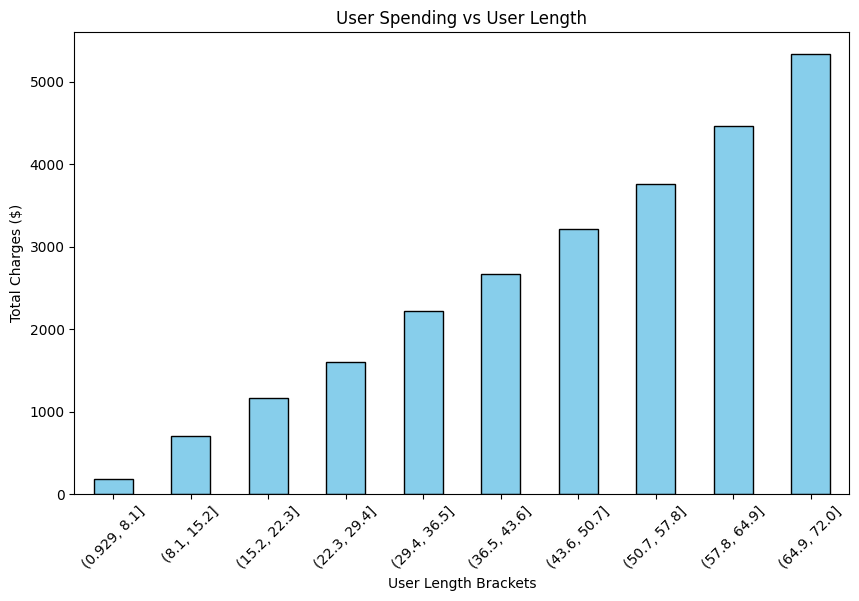

In [19]:
#visualization 
# Create bins (brackets) for user_length (10 bins max)
contract['user_timeframe_bins'] = pd.cut(contract['user_timeframe'], bins=10)

# Group by bins and calculate 'total charges' $ per bin
grouped = contract.groupby('user_timeframe_bins')['TotalCharges'].mean()

# Plot
plt.figure(figsize=(10, 6))
grouped.plot(kind='bar', color='skyblue', edgecolor='black')

# Labels and Title
plt.xlabel('User Length Brackets')
plt.ylabel('Total Charges ($)')
plt.title('User Spending vs User Length')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.show()


In [20]:
contract.columns = contract.columns.str.lower()
contract.head(3)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,beginyear,beginmonth,beginday,endyear,endmonth,endday,user_timeframe,user_timeframe_bins
0,7590-VHVEG,2020-01-01,2020-02-01,1,1,1,29.85,29.85,2020,1,1,0,0,0,1,"(0.929, 8.1]"
1,5575-GNVDE,2017-04-01,2020-02-01,3,0,2,56.95,1889.50,2017,4,1,0,0,0,34,"(29.4, 36.5]"
2,3668-QPYBK,2019-10-01,2019-12-01,1,1,2,53.85,108.15,2019,10,1,2019,12,1,2,"(0.929, 8.1]"


# Evaluate Personal file

None of the files have duplicates, zeros, or empty cells.  Many of the column datatypes are objects rather than integers or floats which are needed for machine learning.  

In [21]:
evaluate_file(personal, duplicate_column="customerID")  


=== File Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

=== Duplicates in 'customerID' ===
Total duplicate values: 0

=== Zero Values ===
Total zero values: 5901

=== Empty (NaN) Cells ===
Total empty cells: 0


,customerID,gender,SeniorCitizen,Partner,Dependents
3503,9821-BESNZ,Male,0,No,No
5149,3970-XGJDU,Female,0,No,No
6583,9617-UDPEU,Female,0,No,No
2006,0224-HJAPT,Male,0,No,No
6786,9820-RMCQV,Female,0,No,No


In [22]:
#confirm only two genders are listed
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

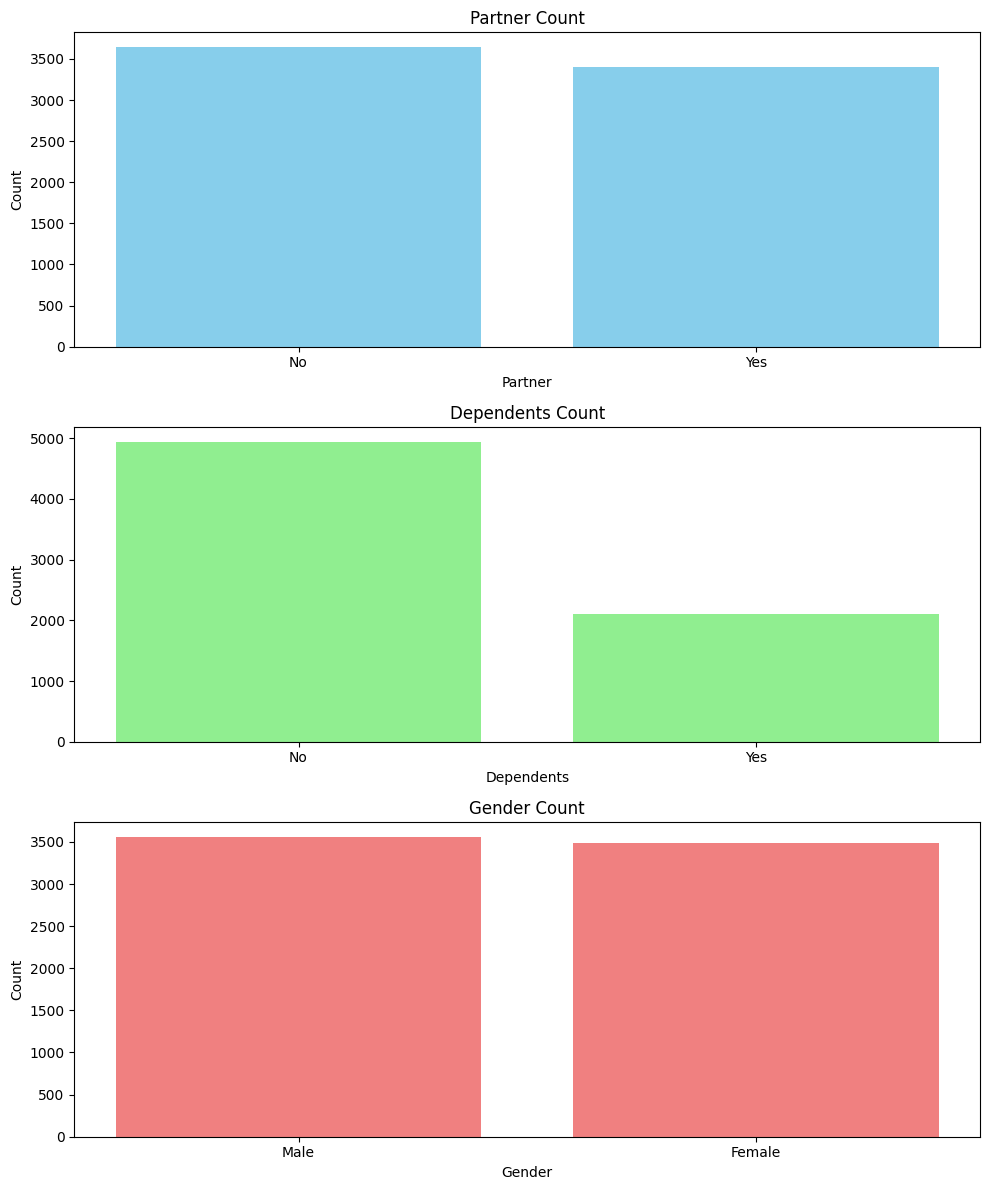

In [23]:
#visualization

# Group by bins and calculate 'total charges' $ per bin
partner_count = personal['Partner'].value_counts()
dependent_count=personal['Dependents'].value_counts()
gender_count=personal['gender'].value_counts()
# Create a subplot for the three bar charts
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Partner bar plot
axes[0].bar(partner_count.index, partner_count.values, color='skyblue')
axes[0].set_title('Partner Count')
axes[0].set_xlabel('Partner')
axes[0].set_ylabel('Count')

# Dependents bar plot
axes[1].bar(dependent_count.index, dependent_count.values, color='lightgreen')
axes[1].set_title('Dependents Count')
axes[1].set_xlabel('Dependents')
axes[1].set_ylabel('Count')

# Gender bar plot
axes[2].bar(gender_count.index, gender_count.values, color='lightcoral')
axes[2].set_title('Gender Count')
axes[2].set_xlabel('Gender')
axes[2].set_ylabel('Count')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [24]:
#replace yes/no with boolean numeric representation 

#replace 'Gender', 'Partner', 'Dependents' with numeric representation
#convert gender column onto a binary.  Male=1 and Female=2
personal['gender']=personal['gender'].replace('Female','2')
personal['gender']=personal['gender'].replace('Male', '1')

personal[['Partner', 'Dependents']] = personal[['Partner', 'Dependents']].replace('No', '0')
personal[['Partner', 'Dependents']] = personal[['Partner', 'Dependents']].replace('Yes', '1')

#convert the gender datatype to an integer 
personal[['Partner', 'Dependents']] = personal[['Partner', 'Dependents']].astype('int')
personal['gender']=personal['gender'].astype('int')

#confirm types
print(personal.dtypes)

customerID       object
gender            int64
SeniorCitizen     int64
Partner           int64
Dependents        int64
dtype: object


In [25]:
personal.columns = personal.columns.str.lower()
personal.head(3)

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,2,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0


# Review Internet File

In [26]:
evaluate_file(internet, duplicate_column="customerID")  


=== File Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

=== Duplicates in 'customerID' ===
Total duplicate values: 0

=== Zero Values ===
Total zero values: 0

=== Empty (NaN) Cells ===
Total empty cells: 0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2876,6656-JWRQX,DSL,No,No,No,Yes,No,No
3955,5018-LXQQG,DSL,Yes,No,No,Yes,No,Yes
4028,3472-OAOOR,DSL,Yes,Yes,No,No,No,No
1132,3870-SPZSI,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
536,2800-VEQXM,Fiber optic,No,No,Yes,No,No,No


In [27]:
#tech support more important to online or streaming customers 
internet['online_tech'] = internet.apply(lambda row: 'Yes' if row['OnlineSecurity'] == 'Yes' and row['OnlineBackup'] == 'Yes' else 'No', axis=1)
internet['streaming_tech'] = internet.apply(lambda row: 'Yes' if row['StreamingTV'] == 'Yes' and row['StreamingMovies'] == 'Yes' else 'No', axis=1)
online=internet['online_tech'].value_counts()
streaming=internet['streaming_tech'].value_counts()

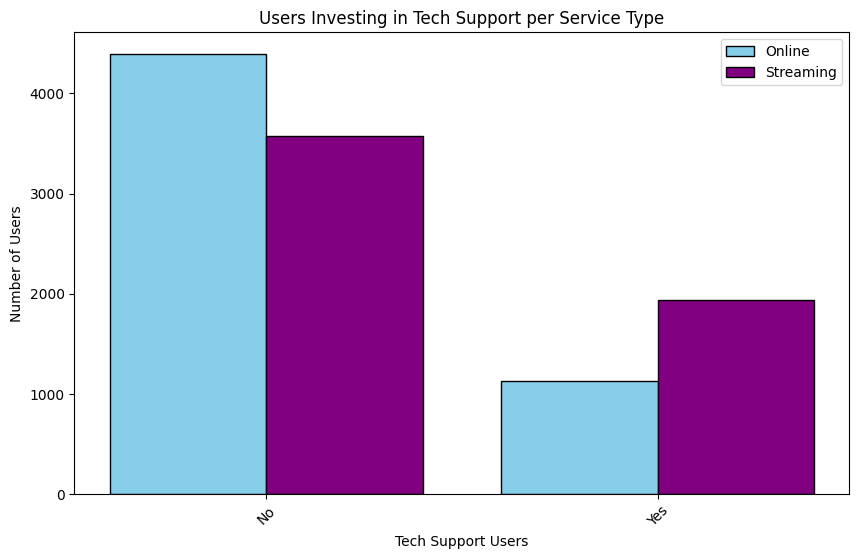

In [28]:
# Convert to lists for plotting
labels = list(online.index)  # Use .index instead of .keys() if it's a DataFrame
online_values = list(online.values)  # Remove parentheses
streaming_values = list(streaming.values)  # Remove parentheses


# Define positions for bars
x = np.arange(len(labels))  # Get x locations
width = 0.4  # Bar width

plt.figure(figsize=(10, 6))

# Plot bars side by side
plt.bar(x - width/2, online_values, width=width, label='Online', color='skyblue', edgecolor='black')
plt.bar(x + width/2, streaming_values, width=width, label='Streaming', color='purple', edgecolor='black')

# Labels and title
plt.xlabel('Tech Support Users')
plt.ylabel('Number of Users')
plt.title('Users Investing in Tech Support per Service Type')
plt.xticks(ticks=x, labels=labels, rotation=45)  # Set x-axis labels
plt.legend()  # Show legend

plt.show()


Note that the majority of users do not choose to have tech support.  The choice of online or streaming options do not effect the issue.  Potentially this is an indication for lack of trust of the company.  

In [29]:
#replace yes/no with boolean numeric representation 
for col in internet.columns:
    internet[col] = internet[col].replace({'Yes': 1, 'No': 0})

internet.head(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,online_tech,streaming_tech
0,7590-VHVEG,DSL,0,1,0,0,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0,1,0


In [30]:
print(internet['InternetService'].value_counts())


Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64


In [31]:
internet=internet.drop('online_tech',axis=1)


In [32]:
internet=internet.drop('streaming_tech',axis=1)

In [33]:
#replace 'InernetService' with numeric representation 
internet['InternetService']=internet['InternetService'].replace('Fiber optic','1')
internet['InternetService']=internet['InternetService'].replace('DSL','2')

#confirm types
print(internet.dtypes)

customerID          object
InternetService     object
OnlineSecurity       int64
OnlineBackup         int64
DeviceProtection     int64
TechSupport          int64
StreamingTV          int64
StreamingMovies      int64
dtype: object


In [34]:
internet['InternetService']=internet['InternetService'].astype(int)
internet.dtypes

customerID          object
InternetService      int64
OnlineSecurity       int64
OnlineBackup         int64
DeviceProtection     int64
TechSupport          int64
StreamingTV          int64
StreamingMovies      int64
dtype: object

In [35]:
#make all columns be lower case
internet.columns = internet.columns.str.lower()
internet.head(3)

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,2,0,1,0,0,0,0
1,5575-GNVDE,2,1,0,1,0,0,0
2,3668-QPYBK,2,1,1,0,0,0,0


# Evaluate Phone File

In [36]:
evaluate_file(phone, duplicate_column="customerID") 


=== File Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

=== Duplicates in 'customerID' ===
Total duplicate values: 0

=== Zero Values ===
Total zero values: 0

=== Empty (NaN) Cells ===
Total empty cells: 0


,customerID,MultipleLines
2089,1587-FKLZB,Yes
1268,9518-RWHZL,Yes
4086,2830-LEWOA,No
3400,0508-OOLTO,No
4625,6861-OKBCE,No


In [37]:
#replace MultipleLines with numeric representation 
phone['MultipleLines']=phone['MultipleLines'].replace('Yes','1')
phone['MultipleLines']=phone['MultipleLines'].replace('No','0')

#force all columns IDs to be lowercase
phone.columns = phone.columns.str.lower()

#confirm types
print(phone.dtypes)

customerid       object
multiplelines    object
dtype: object


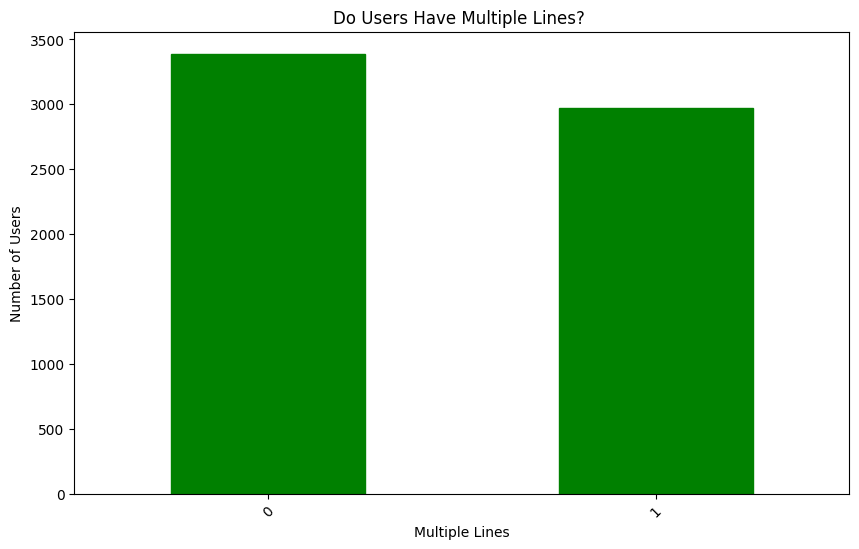

In [38]:
#make some visualizations 
line_research=phone['multiplelines'].value_counts()
plt.figure(figsize=(10, 6))
line_research.plot(kind='bar', color='green', edgecolor='green')

# Labels and Title
plt.xlabel('Multiple Lines')
plt.ylabel('Number of Users')
plt.title('Do Users Have Multiple Lines? ')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.show()

## Project Plan 

# Merge DF

In [39]:
# Randomly sample 5,000 rows from each dataframe (if they have at least 5k rows)
internet_sample = internet.sample(n=5000, random_state=42, replace=False)
contract_sample = contract.sample(n=5000, random_state=42, replace=False)
phone_sample = phone.sample(n=5000, random_state=42, replace=False)
personal_sample =personal.sample(n=5000, random_state=42, replace=False)

In [40]:
#entire = internet_sample.merge(contract_sample, on='customerid', how='outer').merge(phone_sample, on='customerid', how='outer').merge(personal_sample, on='customerid', how='outer')
entire = internet.merge(contract, on='customerid', how='outer').merge(personal, on='customerid', how='outer').merge(phone, on='customerid', how='outer')

In [41]:
#look for any changes post merge
evaluate_file(entire, duplicate_column="customerid") 


=== File Info ===
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customerid           7043 non-null   object        
 1   internetservice      5517 non-null   float64       
 2   onlinesecurity       5517 non-null   float64       
 3   onlinebackup         5517 non-null   float64       
 4   deviceprotection     5517 non-null   float64       
 5   techsupport          5517 non-null   float64       
 6   streamingtv          5517 non-null   float64       
 7   streamingmovies      5517 non-null   float64       
 8   begindate            7032 non-null   datetime64[ns]
 9   enddate              7032 non-null   datetime64[ns]
 10  type                 7032 non-null   float64       
 11  paperlessbilling     7032 non-null   float64       
 12  paymentmethod        7032 non-null   float64       
 13  monthlycharges

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,begindate,enddate,...,endyear,endmonth,endday,user_timeframe,user_timeframe_bins,gender,seniorcitizen,partner,dependents,multiplelines
4820,0201-MIBOL,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2014-08-01,2020-02-01,...,0.0,0.0,0.0,66.0,"(64.9, 72.0]",2,1,0,0,1
5008,7739-LAXOG,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2017-03-01,2019-11-01,...,2019.0,11.0,1.0,32.0,"(29.4, 36.5]",2,0,1,1,1
2166,2250-IVBWA,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2014-10-01,2020-02-01,...,0.0,0.0,0.0,64.0,"(57.8, 64.9]",1,0,1,1,0
4714,2959-FENLU,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-05-01,2020-02-01,...,0.0,0.0,0.0,9.0,"(8.1, 15.2]",2,0,0,0,0
2021,4074-SJFFA,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2019-12-01,2020-01-01,...,2020.0,1.0,1.0,1.0,"(0.929, 8.1]",2,0,0,0,0


In [42]:
#drop columns which will not be needed any longer 
entire=entire.drop(['user_timeframe_bins'], axis=1)

In [43]:
#ther are 11529 NaN values
#Replace NaN values with 0
entire = entire.fillna(0)

In [44]:
evaluate_file(entire, duplicate_column="customerid") 


=== File Info ===
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   internetservice   7043 non-null   float64
 2   onlinesecurity    7043 non-null   float64
 3   onlinebackup      7043 non-null   float64
 4   deviceprotection  7043 non-null   float64
 5   techsupport       7043 non-null   float64
 6   streamingtv       7043 non-null   float64
 7   streamingmovies   7043 non-null   float64
 8   begindate         7043 non-null   object 
 9   enddate           7043 non-null   object 
 10  type              7043 non-null   float64
 11  paperlessbilling  7043 non-null   float64
 12  paymentmethod     7043 non-null   float64
 13  monthlycharges    7043 non-null   float64
 14  totalcharges      7043 non-null   float64
 15  beginyear         7043 non-null   float64
 16  beginmonth        7043 

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,begindate,enddate,...,beginday,endyear,endmonth,endday,user_timeframe,gender,seniorcitizen,partner,dependents,multiplelines
54,1215-FIGMP,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2015-02-01 00:00:00,2020-02-01 00:00:00,...,1.0,0.0,0.0,0.0,60.0,1,0,0,0,1
360,4110-PFEUZ,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-09-01 00:00:00,2019-10-01 00:00:00,...,1.0,2019.0,10.0,1.0,1.0,2,0,0,0,0
4513,1818-ESQMW,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2017-11-01 00:00:00,2020-02-01 00:00:00,...,1.0,0.0,0.0,0.0,27.0,2,0,0,0,0
1873,0013-SMEOE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2014-03-01 00:00:00,2020-02-01 00:00:00,...,1.0,0.0,0.0,0.0,71.0,2,1,1,0,0
2299,7740-BTPUX,1.0,0.0,1.0,1.0,1.0,1.0,1.0,2015-07-01 00:00:00,2020-02-01 00:00:00,...,1.0,0.0,0.0,0.0,55.0,1,1,1,0,1


In [45]:
# Ensure 'enddate' is in datetime format
entire['enddate'] = pd.to_datetime(entire['enddate'], errors='coerce')

# converting to int
entire['multiplelines'] = entire['multiplelines'].astype(int)

In [46]:
#use feature engineering to create new useful columns. 

#trust (if they have techsupport, deviceprotection, and online security. are still customer?)
entire['trust']=((entire['techsupport'] == '1') & 
              (entire['deviceprotection'] == '1') & 
              (entire['onlinesecurity'] == '1') & 
              (entire['endyear'] == '0')).astype(int)  # Convert to 1/0

entire['trust'].value_counts()

0    7043
Name: trust, dtype: int64

In [47]:
#determine avg. of spending. rank if high/low spend.  see relationship to churn
av_spend=entire['totalcharges'].mean()
print(av_spend)
entire['type_of_spender']=(entire['totalcharges']>av_spend).astype(int)
print(entire['type_of_spender'].value_counts())

2279.7343035638223
0    4394
1    2649
Name: type_of_spender, dtype: int64


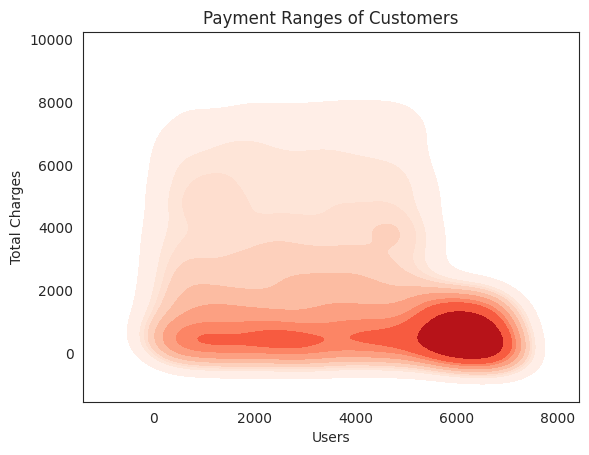

In [48]:
#create with total spent and customers index 
sns.set_style("white")
sns.kdeplot(x=entire.index, y=entire['totalcharges'], cmap="Reds", fill=True)
plt.xlabel('Users')
plt.ylabel('Total Charges')
plt.title('Payment Ranges of Customers')
plt.show()

In [49]:
#drop columns which will not be needed any longer 
entire=entire.drop(['begindate','customerid','beginyear', 'beginmonth', 'beginday','endmonth', 'endday','type_of_spender', 'trust'], axis=1)

In [50]:
#examine class balance. everything counted in '0' indiates still current customer. 
entire['endyear'].value_counts()

0.0       5174
2019.0    1409
2020.0     460
Name: endyear, dtype: int64

In [51]:
#add 'churn' column 
entire['churn'] = ((entire['endyear'] != 0) & (entire['endyear'] != 2025)).astype(int)


In [52]:
entire.head()

,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,enddate,type,paperlessbilling,...,monthlycharges,totalcharges,endyear,user_timeframe,gender,seniorcitizen,partner,dependents,multiplelines,churn
0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,2020-02-01,1.0,1.0,...,29.85,29.85,0.0,1.0,2,0,1,0,0,0
1,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2020-02-01,3.0,0.0,...,56.95,1889.50,0.0,34.0,1,0,0,0,0,0
2,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2019-12-01,1.0,1.0,...,53.85,108.15,2019.0,2.0,1,0,0,0,0,1
3,2.0,1.0,0.0,1.0,1.0,0.0,0.0,2020-02-01,3.0,0.0,...,42.30,1840.75,0.0,45.0,1,0,0,0,0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-01,1.0,1.0,...,70.70,151.65,2019.0,2.0,2,0,0,0,0,1


In [53]:
# Sort by 'enddate' (ascending) and then by 'monthly charges' (ascending)
entire = entire.sort_values(by=['enddate', 'monthlycharges'], ascending=[True, True])

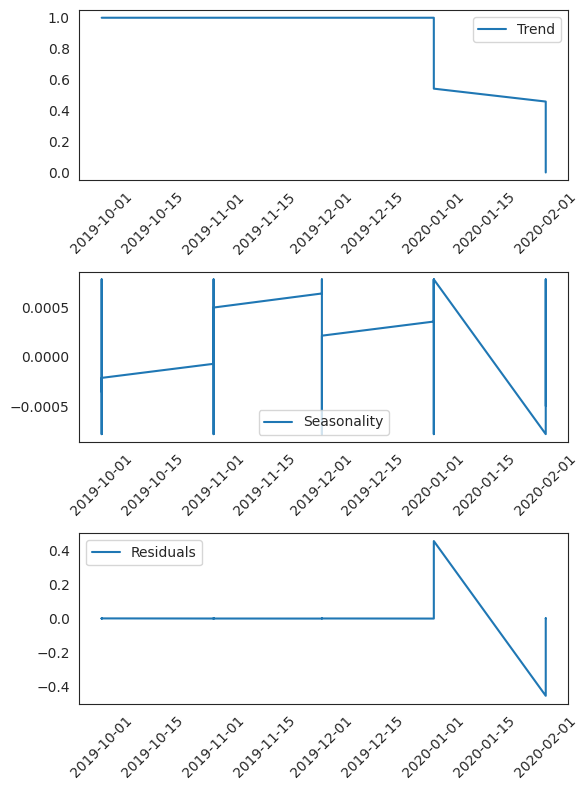

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set 'enddate' as index (if not already)
entire.set_index('enddate', inplace=True)

# Select the column representing churn counts over time (change 'Churn_Count' to the actual column name)
if 'churn' in entire.columns:
    decomposed = seasonal_decompose(entire['churn'], model='additive', period=12)  

    # Plot results
    plt.figure(figsize=(6, 8))
    plt.subplot(311)
    plt.plot(decomposed.trend, label="Trend")
    plt.xticks(rotation=45)
    plt.legend()

    plt.subplot(312)
    plt.plot(decomposed.seasonal, label="Seasonality")
    plt.xticks(rotation=45)
    plt.legend()

    plt.subplot(313)
    plt.plot(decomposed.resid, label="Residuals")
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Error: Column 'Churn_Count' not found in dataset.")


In [55]:
entire.columns

Index(['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'type',
       'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges',
       'endyear', 'user_timeframe', 'gender', 'seniorcitizen', 'partner',
       'dependents', 'multiplelines', 'churn'],
      dtype='object')

In [56]:
entire = entire.dropna().reset_index(drop=True)

In [57]:
#split source data into test, training and validation set of 6:2:2
#create split of 60% to training and 40% assigned as temp 
entire_train, entire_temp=train_test_split(entire, test_size=0.4, random_state=54321)
#create split from beta_temp to _validation and _test dataframes. Sources 20% of data to each. 
entire_valid, entire_test=train_test_split(entire_temp, test_size=0.5, random_state=54321)

In [58]:
#define variables for training 
features_train = entire_train.drop(['churn','user_timeframe'],axis=1)
target_train = entire_train['churn']
#define variables for testing
features_test = entire_test.drop(['churn','user_timeframe'],axis=1)
target_test = entire_test['churn']
#define variables for validation 
features_valid = entire_valid.drop(['churn','user_timeframe'],axis=1)
target_valid = entire_valid['churn']

In [59]:
from sklearn.utils import shuffle

def upsample_entire(df, column, values, num_rows_to_add):

    # Ensure the column is numeric 
    df[column] = pd.to_numeric(df[column], errors='coerce')

    # Filter rows where the column has the target values (2019 or 2020)
    df_target = df[df[column].isin(values)]

    # Check if df_target is empty
    if df_target.empty:
        raise ValueError(f"No rows found in '{column}' with values {values}. Upsampling cannot proceed.")

    # Calculate how many times to duplicate the rows
    num_target_rows = len(df_target)
    repeat_factor = num_rows_to_add // num_target_rows  # Integer division
    remainder = num_rows_to_add % num_target_rows  # Extra rows needed

    # Duplicate rows
    df_upsampled = pd.concat([df_target] * repeat_factor, ignore_index=True)

    # If remainder exists, sample additional rows
    if remainder > 0:
        df_extra = df_target.sample(n=remainder, replace=True, random_state=12345)
        df_upsampled = pd.concat([df_upsampled, df_extra], ignore_index=True)

    # Combine with original dataset
    df_final = pd.concat([df, df_upsampled], ignore_index=True)

    # Shuffle to maintain randomness
    df_final = shuffle(df_final, random_state=12345)

    return df_final

In [60]:
# Add exactly 3,294 rows where 'endyear' is 2019 or 2020
entire = upsample_entire(features_train, 'endyear', [2019, 2020], 3294)
print(f"Features_train upsampled DataFrame has {len(entire)} rows.")


Features_train upsampled DataFrame has 7519 rows.


In [61]:
features_train = features_train.drop(['endyear'], axis=1)
features_test = features_test.drop(['endyear'], axis=1)
features_valid = features_valid.drop(['endyear'], axis=1)


In [62]:
scaler = StandardScaler()  # Initialize the scaler

# Fit and transform training data
features_train = scaler.fit_transform(features_train)

# Only transform test data (do NOT fit again!)
features_test = scaler.transform(features_test)


In [63]:
features_train.shape

(4225, 17)

<div class="info">
<b>Student comment V1</b> <a class="tocSkip"></a>

original n of 1226 was the len of limiting factor of target_train.  Features_train will need to be sampled since it was  upsampled to account for the class imbalance 
</div>


Running GridSearchCV for RandomForest...
Best RandomForest Parameters: {'max_depth': 10, 'n_estimators': 100, 'random_state': 42}

Running GridSearchCV for DecisionTree...
Best DecisionTree Parameters: {'max_depth': 5, 'random_state': 42}

Running GridSearchCV for GradientBoosting...
Best GradientBoosting Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'random_state': 42}

Running GridSearchCV for LogisticRegression...
Best LogisticRegression Parameters: {}

Running GridSearchCV for XGBClassifier...


/opt/conda/envs/python3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/envs/python3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/envs/python3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/envs/python3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/envs/python3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/envs/python3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best XGBClassifier Parameters: {}

Running GridSearchCV for LGBMClassifier...
Best LGBMClassifier Parameters: {}

Running GridSearchCV for CatBoost...
Learning rate set to 0.017329
0:	learn: 0.6810317	total: 48.2ms	remaining: 48.1s
1:	learn: 0.6698019	total: 49.5ms	remaining: 24.7s
2:	learn: 0.6597486	total: 50.6ms	remaining: 16.8s
3:	learn: 0.6505683	total: 51.8ms	remaining: 12.9s
4:	learn: 0.6410712	total: 52.9ms	remaining: 10.5s
5:	learn: 0.6324711	total: 53.8ms	remaining: 8.91s
6:	learn: 0.6231135	total: 54.9ms	remaining: 7.79s
7:	learn: 0.6145048	total: 56.1ms	remaining: 6.95s
8:	learn: 0.6059158	total: 57.3ms	remaining: 6.31s
9:	learn: 0.5989194	total: 57.9ms	remaining: 5.74s
10:	learn: 0.5915093	total: 59.1ms	remaining: 5.31s
11:	l

166:	learn: 0.3894165	total: 244ms	remaining: 1.22s
167:	learn: 0.3890363	total: 245ms	remaining: 1.21s
168:	learn: 0.3888356	total: 247ms	remaining: 1.21s
169:	learn: 0.3886311	total: 248ms	remaining: 1.21s
170:	learn: 0.3884610	total: 249ms	remaining: 1.21s
171:	learn: 0.3882798	total: 250ms	remaining: 1.2s
172:	learn: 0.3879826	total: 251ms	remaining: 1.2s
173:	learn: 0.3879115	total: 252ms	remaining: 1.2s
174:	learn: 0.3876164	total: 253ms	remaining: 1.19s
175:	learn: 0.3874089	total: 255ms	remaining: 1.19s
176:	learn: 0.3872666	total: 256ms	remaining: 1.19s
177:	learn: 0.3869909	total: 257ms	remaining: 1.19s
178:	learn: 0.3868350	total: 258ms	remaining: 1.19s
179:	learn: 0.3867029	total: 260ms	remaining: 1.18s
180:	learn: 0.3863580	total: 261ms	remaining: 1.18s
181:	learn: 0.3861800	total: 262ms	remaining: 1.18s
182:	learn: 0.3859895	total: 263ms	remaining: 1.18s
183:	learn: 0.3857819	total: 264ms	remaining: 1.17s
184:	learn: 0.3853816	total: 266ms	remaining: 1.17s
185:	learn: 0.3

329:	learn: 0.3619465	total: 439ms	remaining: 892ms
330:	learn: 0.3618491	total: 441ms	remaining: 891ms
331:	learn: 0.3616740	total: 442ms	remaining: 889ms
332:	learn: 0.3615483	total: 443ms	remaining: 888ms
333:	learn: 0.3614070	total: 444ms	remaining: 886ms
334:	learn: 0.3613435	total: 450ms	remaining: 893ms
335:	learn: 0.3612096	total: 451ms	remaining: 892ms
336:	learn: 0.3611190	total: 453ms	remaining: 891ms
337:	learn: 0.3610971	total: 454ms	remaining: 888ms
338:	learn: 0.3609294	total: 455ms	remaining: 887ms
339:	learn: 0.3608045	total: 456ms	remaining: 885ms
340:	learn: 0.3606589	total: 457ms	remaining: 884ms
341:	learn: 0.3605854	total: 458ms	remaining: 882ms
342:	learn: 0.3605305	total: 460ms	remaining: 880ms
343:	learn: 0.3604145	total: 461ms	remaining: 879ms
344:	learn: 0.3602704	total: 462ms	remaining: 877ms
345:	learn: 0.3602663	total: 463ms	remaining: 874ms
346:	learn: 0.3601053	total: 464ms	remaining: 873ms
347:	learn: 0.3599156	total: 465ms	remaining: 871ms
348:	learn: 

489:	learn: 0.3409245	total: 636ms	remaining: 662ms
490:	learn: 0.3407434	total: 637ms	remaining: 661ms
491:	learn: 0.3407013	total: 638ms	remaining: 659ms
492:	learn: 0.3405252	total: 640ms	remaining: 658ms
493:	learn: 0.3404171	total: 641ms	remaining: 656ms
494:	learn: 0.3402749	total: 642ms	remaining: 655ms
495:	learn: 0.3402123	total: 643ms	remaining: 654ms
496:	learn: 0.3401652	total: 644ms	remaining: 652ms
497:	learn: 0.3400390	total: 646ms	remaining: 651ms
498:	learn: 0.3399102	total: 647ms	remaining: 649ms
499:	learn: 0.3397967	total: 648ms	remaining: 648ms
500:	learn: 0.3396569	total: 649ms	remaining: 647ms
501:	learn: 0.3395013	total: 651ms	remaining: 645ms
502:	learn: 0.3393197	total: 652ms	remaining: 644ms
503:	learn: 0.3392348	total: 653ms	remaining: 643ms
504:	learn: 0.3391626	total: 654ms	remaining: 641ms
505:	learn: 0.3389861	total: 655ms	remaining: 640ms
506:	learn: 0.3388880	total: 657ms	remaining: 638ms
507:	learn: 0.3386918	total: 658ms	remaining: 637ms
508:	learn: 

653:	learn: 0.3233413	total: 832ms	remaining: 440ms
654:	learn: 0.3232074	total: 833ms	remaining: 439ms
655:	learn: 0.3230675	total: 834ms	remaining: 437ms
656:	learn: 0.3229973	total: 839ms	remaining: 438ms
657:	learn: 0.3228212	total: 841ms	remaining: 437ms
658:	learn: 0.3225723	total: 842ms	remaining: 436ms
659:	learn: 0.3225326	total: 843ms	remaining: 434ms
660:	learn: 0.3223708	total: 844ms	remaining: 433ms
661:	learn: 0.3222152	total: 846ms	remaining: 432ms
662:	learn: 0.3221314	total: 847ms	remaining: 430ms
663:	learn: 0.3220239	total: 848ms	remaining: 429ms
664:	learn: 0.3219086	total: 849ms	remaining: 428ms
665:	learn: 0.3218194	total: 850ms	remaining: 426ms
666:	learn: 0.3217276	total: 852ms	remaining: 425ms
667:	learn: 0.3215069	total: 853ms	remaining: 424ms
668:	learn: 0.3214199	total: 854ms	remaining: 423ms
669:	learn: 0.3212910	total: 855ms	remaining: 421ms
670:	learn: 0.3211539	total: 857ms	remaining: 420ms
671:	learn: 0.3211158	total: 858ms	remaining: 419ms
672:	learn: 

811:	learn: 0.3053357	total: 1.03s	remaining: 238ms
812:	learn: 0.3052563	total: 1.03s	remaining: 237ms
813:	learn: 0.3051296	total: 1.03s	remaining: 236ms
814:	learn: 0.3050550	total: 1.03s	remaining: 235ms
815:	learn: 0.3049623	total: 1.04s	remaining: 234ms
816:	learn: 0.3049133	total: 1.04s	remaining: 233ms
817:	learn: 0.3047559	total: 1.04s	remaining: 231ms
818:	learn: 0.3046912	total: 1.04s	remaining: 230ms
819:	learn: 0.3045940	total: 1.04s	remaining: 229ms
820:	learn: 0.3045590	total: 1.04s	remaining: 227ms
821:	learn: 0.3044316	total: 1.04s	remaining: 226ms
822:	learn: 0.3043272	total: 1.04s	remaining: 225ms
823:	learn: 0.3042526	total: 1.05s	remaining: 224ms
824:	learn: 0.3041742	total: 1.05s	remaining: 222ms
825:	learn: 0.3041282	total: 1.05s	remaining: 221ms
826:	learn: 0.3040767	total: 1.05s	remaining: 220ms
827:	learn: 0.3040078	total: 1.05s	remaining: 218ms
828:	learn: 0.3039526	total: 1.05s	remaining: 217ms
829:	learn: 0.3038436	total: 1.05s	remaining: 216ms
830:	learn: 

969:	learn: 0.2907331	total: 1.22s	remaining: 37.9ms
970:	learn: 0.2906106	total: 1.23s	remaining: 36.7ms
971:	learn: 0.2905819	total: 1.23s	remaining: 35.5ms
972:	learn: 0.2904811	total: 1.23s	remaining: 34.2ms
973:	learn: 0.2903886	total: 1.23s	remaining: 32.9ms
974:	learn: 0.2903339	total: 1.23s	remaining: 31.7ms
975:	learn: 0.2902456	total: 1.24s	remaining: 30.4ms
976:	learn: 0.2901712	total: 1.24s	remaining: 29.1ms
977:	learn: 0.2901450	total: 1.24s	remaining: 27.9ms
978:	learn: 0.2900337	total: 1.24s	remaining: 26.6ms
979:	learn: 0.2899739	total: 1.24s	remaining: 25.3ms
980:	learn: 0.2899039	total: 1.24s	remaining: 24.1ms
981:	learn: 0.2897603	total: 1.24s	remaining: 22.8ms
982:	learn: 0.2896812	total: 1.24s	remaining: 21.5ms
983:	learn: 0.2895074	total: 1.25s	remaining: 20.3ms
984:	learn: 0.2893948	total: 1.25s	remaining: 19ms
985:	learn: 0.2892875	total: 1.25s	remaining: 17.7ms
986:	learn: 0.2892159	total: 1.25s	remaining: 16.5ms
987:	learn: 0.2891183	total: 1.25s	remaining: 15

182:	learn: 0.3836520	total: 219ms	remaining: 977ms
183:	learn: 0.3834913	total: 220ms	remaining: 977ms
184:	learn: 0.3832722	total: 221ms	remaining: 975ms
185:	learn: 0.3830051	total: 223ms	remaining: 974ms
186:	learn: 0.3828327	total: 224ms	remaining: 975ms
187:	learn: 0.3826226	total: 226ms	remaining: 974ms
188:	learn: 0.3824435	total: 227ms	remaining: 973ms
189:	learn: 0.3823510	total: 228ms	remaining: 972ms
190:	learn: 0.3821917	total: 229ms	remaining: 971ms
191:	learn: 0.3820357	total: 230ms	remaining: 969ms
192:	learn: 0.3817190	total: 232ms	remaining: 968ms
193:	learn: 0.3815633	total: 233ms	remaining: 967ms
194:	learn: 0.3811647	total: 234ms	remaining: 966ms
195:	learn: 0.3808015	total: 235ms	remaining: 965ms
196:	learn: 0.3805366	total: 236ms	remaining: 964ms
197:	learn: 0.3803351	total: 238ms	remaining: 962ms
198:	learn: 0.3802168	total: 239ms	remaining: 961ms
199:	learn: 0.3800325	total: 240ms	remaining: 960ms
200:	learn: 0.3798934	total: 241ms	remaining: 958ms
201:	learn: 

348:	learn: 0.3567182	total: 416ms	remaining: 776ms
349:	learn: 0.3564031	total: 418ms	remaining: 776ms
350:	learn: 0.3563181	total: 419ms	remaining: 775ms
351:	learn: 0.3562156	total: 420ms	remaining: 774ms
352:	learn: 0.3560601	total: 422ms	remaining: 773ms
353:	learn: 0.3559719	total: 423ms	remaining: 772ms
354:	learn: 0.3558788	total: 424ms	remaining: 770ms
355:	learn: 0.3556614	total: 425ms	remaining: 769ms
356:	learn: 0.3555517	total: 426ms	remaining: 768ms
357:	learn: 0.3554657	total: 427ms	remaining: 767ms
358:	learn: 0.3553099	total: 429ms	remaining: 765ms
359:	learn: 0.3550422	total: 430ms	remaining: 764ms
360:	learn: 0.3549511	total: 431ms	remaining: 763ms
361:	learn: 0.3547909	total: 432ms	remaining: 762ms
362:	learn: 0.3547830	total: 433ms	remaining: 759ms
363:	learn: 0.3547191	total: 434ms	remaining: 758ms
364:	learn: 0.3546038	total: 435ms	remaining: 757ms
365:	learn: 0.3544667	total: 436ms	remaining: 756ms
366:	learn: 0.3543090	total: 437ms	remaining: 755ms
367:	learn: 

516:	learn: 0.3334198	total: 612ms	remaining: 572ms
517:	learn: 0.3333091	total: 614ms	remaining: 571ms
518:	learn: 0.3331682	total: 615ms	remaining: 570ms
519:	learn: 0.3330731	total: 616ms	remaining: 569ms
520:	learn: 0.3329039	total: 618ms	remaining: 568ms
521:	learn: 0.3328107	total: 619ms	remaining: 567ms
522:	learn: 0.3327207	total: 620ms	remaining: 566ms
523:	learn: 0.3325714	total: 621ms	remaining: 564ms
524:	learn: 0.3324740	total: 622ms	remaining: 563ms
525:	learn: 0.3323565	total: 624ms	remaining: 562ms
526:	learn: 0.3322205	total: 625ms	remaining: 561ms
527:	learn: 0.3320991	total: 626ms	remaining: 560ms
528:	learn: 0.3319345	total: 627ms	remaining: 558ms
529:	learn: 0.3318178	total: 628ms	remaining: 557ms
530:	learn: 0.3317511	total: 630ms	remaining: 556ms
531:	learn: 0.3316013	total: 631ms	remaining: 555ms
532:	learn: 0.3314827	total: 632ms	remaining: 554ms
533:	learn: 0.3313707	total: 633ms	remaining: 553ms
534:	learn: 0.3313228	total: 634ms	remaining: 551ms
535:	learn: 

674:	learn: 0.3161953	total: 809ms	remaining: 389ms
675:	learn: 0.3161162	total: 810ms	remaining: 388ms
676:	learn: 0.3160277	total: 811ms	remaining: 387ms
677:	learn: 0.3159703	total: 812ms	remaining: 386ms
678:	learn: 0.3158394	total: 814ms	remaining: 385ms
679:	learn: 0.3157335	total: 815ms	remaining: 383ms
680:	learn: 0.3155686	total: 816ms	remaining: 382ms
681:	learn: 0.3154800	total: 817ms	remaining: 381ms
682:	learn: 0.3153989	total: 819ms	remaining: 380ms
683:	learn: 0.3153241	total: 820ms	remaining: 379ms
684:	learn: 0.3151787	total: 821ms	remaining: 378ms
685:	learn: 0.3151006	total: 822ms	remaining: 376ms
686:	learn: 0.3150245	total: 823ms	remaining: 375ms
687:	learn: 0.3149780	total: 825ms	remaining: 374ms
688:	learn: 0.3148603	total: 826ms	remaining: 373ms
689:	learn: 0.3147451	total: 827ms	remaining: 372ms
690:	learn: 0.3146726	total: 828ms	remaining: 370ms
691:	learn: 0.3145615	total: 830ms	remaining: 369ms
692:	learn: 0.3143774	total: 831ms	remaining: 368ms
693:	learn: 

984:	learn: 0.2837857	total: 1.2s	remaining: 18.3ms
985:	learn: 0.2837177	total: 1.2s	remaining: 17.1ms
986:	learn: 0.2836791	total: 1.2s	remaining: 15.8ms
987:	learn: 0.2836135	total: 1.2s	remaining: 14.6ms
988:	learn: 0.2833871	total: 1.21s	remaining: 13.4ms
989:	learn: 0.2833189	total: 1.21s	remaining: 12.2ms
990:	learn: 0.2832353	total: 1.21s	remaining: 11ms
991:	learn: 0.2831094	total: 1.21s	remaining: 9.75ms
992:	learn: 0.2829998	total: 1.21s	remaining: 8.53ms
993:	learn: 0.2829642	total: 1.21s	remaining: 7.31ms
994:	learn: 0.2829189	total: 1.21s	remaining: 6.09ms
995:	learn: 0.2828466	total: 1.21s	remaining: 4.87ms
996:	learn: 0.2827399	total: 1.21s	remaining: 3.65ms
997:	learn: 0.2826420	total: 1.22s	remaining: 2.44ms
998:	learn: 0.2825848	total: 1.22s	remaining: 1.22ms
999:	learn: 0.2824632	total: 1.22s	remaining: 0us
Learning rate set to 0.017329
0:	learn: 0.6809759	total: 1.6ms	remaining: 1.6s
1:	learn: 0.6695937	total: 2.88ms	remaining: 1.43s
2:	learn: 0.6593237	total: 4.09

148:	learn: 0.3936791	total: 198ms	remaining: 1.13s
149:	learn: 0.3934503	total: 199ms	remaining: 1.13s
150:	learn: 0.3931640	total: 201ms	remaining: 1.13s
151:	learn: 0.3928999	total: 202ms	remaining: 1.13s
152:	learn: 0.3926943	total: 203ms	remaining: 1.12s
153:	learn: 0.3925193	total: 204ms	remaining: 1.12s
154:	learn: 0.3921839	total: 205ms	remaining: 1.12s
155:	learn: 0.3916786	total: 207ms	remaining: 1.12s
156:	learn: 0.3913423	total: 208ms	remaining: 1.12s
157:	learn: 0.3910647	total: 209ms	remaining: 1.11s
158:	learn: 0.3907564	total: 210ms	remaining: 1.11s
159:	learn: 0.3905879	total: 212ms	remaining: 1.11s
160:	learn: 0.3903064	total: 213ms	remaining: 1.11s
161:	learn: 0.3899896	total: 214ms	remaining: 1.11s
162:	learn: 0.3897164	total: 215ms	remaining: 1.1s
163:	learn: 0.3894809	total: 217ms	remaining: 1.1s
164:	learn: 0.3892017	total: 218ms	remaining: 1.1s
165:	learn: 0.3889447	total: 219ms	remaining: 1.1s
166:	learn: 0.3887861	total: 220ms	remaining: 1.1s
167:	learn: 0.388

306:	learn: 0.3623302	total: 394ms	remaining: 889ms
307:	learn: 0.3621224	total: 395ms	remaining: 888ms
308:	learn: 0.3619133	total: 396ms	remaining: 886ms
309:	learn: 0.3616038	total: 398ms	remaining: 885ms
310:	learn: 0.3615082	total: 399ms	remaining: 884ms
311:	learn: 0.3612610	total: 400ms	remaining: 882ms
312:	learn: 0.3612172	total: 401ms	remaining: 880ms
313:	learn: 0.3611016	total: 402ms	remaining: 878ms
314:	learn: 0.3609500	total: 403ms	remaining: 877ms
315:	learn: 0.3608872	total: 404ms	remaining: 875ms
316:	learn: 0.3608226	total: 406ms	remaining: 875ms
317:	learn: 0.3606846	total: 407ms	remaining: 874ms
318:	learn: 0.3605012	total: 409ms	remaining: 873ms
319:	learn: 0.3603695	total: 410ms	remaining: 872ms
320:	learn: 0.3602634	total: 412ms	remaining: 872ms
321:	learn: 0.3601997	total: 414ms	remaining: 871ms
322:	learn: 0.3600092	total: 415ms	remaining: 870ms
323:	learn: 0.3598016	total: 416ms	remaining: 868ms
324:	learn: 0.3596506	total: 417ms	remaining: 867ms
325:	learn: 

619:	learn: 0.3213683	total: 785ms	remaining: 481ms
620:	learn: 0.3211984	total: 787ms	remaining: 480ms
621:	learn: 0.3211156	total: 788ms	remaining: 479ms
622:	learn: 0.3208957	total: 789ms	remaining: 478ms
623:	learn: 0.3207983	total: 791ms	remaining: 477ms
624:	learn: 0.3206359	total: 792ms	remaining: 475ms
625:	learn: 0.3205365	total: 794ms	remaining: 474ms
626:	learn: 0.3204429	total: 796ms	remaining: 473ms
627:	learn: 0.3203207	total: 797ms	remaining: 472ms
628:	learn: 0.3202176	total: 799ms	remaining: 471ms
629:	learn: 0.3200502	total: 800ms	remaining: 470ms
630:	learn: 0.3198827	total: 802ms	remaining: 469ms
631:	learn: 0.3198057	total: 803ms	remaining: 467ms
632:	learn: 0.3197103	total: 804ms	remaining: 466ms
633:	learn: 0.3196131	total: 805ms	remaining: 465ms
634:	learn: 0.3195308	total: 806ms	remaining: 464ms
635:	learn: 0.3194210	total: 808ms	remaining: 462ms
636:	learn: 0.3193286	total: 809ms	remaining: 461ms
637:	learn: 0.3191980	total: 810ms	remaining: 460ms
638:	learn: 

934:	learn: 0.2868834	total: 1.18s	remaining: 81.9ms
935:	learn: 0.2867784	total: 1.18s	remaining: 80.7ms
936:	learn: 0.2866715	total: 1.18s	remaining: 79.5ms
937:	learn: 0.2866063	total: 1.18s	remaining: 78.2ms
938:	learn: 0.2865269	total: 1.19s	remaining: 77ms
939:	learn: 0.2864683	total: 1.19s	remaining: 75.7ms
940:	learn: 0.2863856	total: 1.19s	remaining: 74.5ms
941:	learn: 0.2862304	total: 1.19s	remaining: 73.2ms
942:	learn: 0.2861436	total: 1.19s	remaining: 71.9ms
943:	learn: 0.2860666	total: 1.19s	remaining: 70.7ms
944:	learn: 0.2859208	total: 1.19s	remaining: 69.4ms
945:	learn: 0.2858346	total: 1.19s	remaining: 68.1ms
946:	learn: 0.2856881	total: 1.2s	remaining: 66.9ms
947:	learn: 0.2856329	total: 1.2s	remaining: 65.6ms
948:	learn: 0.2855424	total: 1.2s	remaining: 64.4ms
949:	learn: 0.2854585	total: 1.2s	remaining: 63.1ms
950:	learn: 0.2853354	total: 1.2s	remaining: 61.9ms
951:	learn: 0.2851833	total: 1.2s	remaining: 60.6ms
952:	learn: 0.2851510	total: 1.2s	remaining: 59.3ms
95

166:	learn: 0.3906512	total: 198ms	remaining: 986ms
167:	learn: 0.3903925	total: 199ms	remaining: 988ms
168:	learn: 0.3901296	total: 201ms	remaining: 987ms
169:	learn: 0.3899210	total: 202ms	remaining: 985ms
170:	learn: 0.3896500	total: 203ms	remaining: 984ms
171:	learn: 0.3893559	total: 204ms	remaining: 983ms
172:	learn: 0.3891054	total: 205ms	remaining: 982ms
173:	learn: 0.3888327	total: 207ms	remaining: 981ms
174:	learn: 0.3886236	total: 208ms	remaining: 980ms
175:	learn: 0.3883138	total: 209ms	remaining: 978ms
176:	learn: 0.3881403	total: 214ms	remaining: 996ms
177:	learn: 0.3881136	total: 215ms	remaining: 993ms
178:	learn: 0.3878642	total: 216ms	remaining: 992ms
179:	learn: 0.3876605	total: 217ms	remaining: 991ms
180:	learn: 0.3875532	total: 218ms	remaining: 988ms
181:	learn: 0.3872798	total: 220ms	remaining: 987ms
182:	learn: 0.3870223	total: 221ms	remaining: 985ms
183:	learn: 0.3868532	total: 222ms	remaining: 984ms
184:	learn: 0.3867657	total: 223ms	remaining: 983ms
185:	learn: 

328:	learn: 0.3632607	total: 394ms	remaining: 805ms
329:	learn: 0.3631852	total: 396ms	remaining: 803ms
330:	learn: 0.3630968	total: 397ms	remaining: 802ms
331:	learn: 0.3628417	total: 398ms	remaining: 801ms
332:	learn: 0.3626270	total: 399ms	remaining: 800ms
333:	learn: 0.3624262	total: 400ms	remaining: 799ms
334:	learn: 0.3623082	total: 402ms	remaining: 797ms
335:	learn: 0.3621544	total: 403ms	remaining: 796ms
336:	learn: 0.3620910	total: 404ms	remaining: 795ms
337:	learn: 0.3619901	total: 405ms	remaining: 794ms
338:	learn: 0.3617849	total: 406ms	remaining: 792ms
339:	learn: 0.3616535	total: 408ms	remaining: 791ms
340:	learn: 0.3615453	total: 409ms	remaining: 790ms
341:	learn: 0.3613543	total: 410ms	remaining: 789ms
342:	learn: 0.3611349	total: 411ms	remaining: 787ms
343:	learn: 0.3609756	total: 412ms	remaining: 786ms
344:	learn: 0.3609090	total: 413ms	remaining: 785ms
345:	learn: 0.3605995	total: 415ms	remaining: 784ms
346:	learn: 0.3605061	total: 416ms	remaining: 782ms
347:	learn: 

489:	learn: 0.3413253	total: 590ms	remaining: 614ms
490:	learn: 0.3412411	total: 591ms	remaining: 613ms
491:	learn: 0.3410858	total: 592ms	remaining: 612ms
492:	learn: 0.3409722	total: 594ms	remaining: 610ms
493:	learn: 0.3407987	total: 595ms	remaining: 609ms
494:	learn: 0.3407908	total: 595ms	remaining: 607ms
495:	learn: 0.3407129	total: 596ms	remaining: 606ms
496:	learn: 0.3406447	total: 598ms	remaining: 605ms
497:	learn: 0.3405680	total: 599ms	remaining: 604ms
498:	learn: 0.3404105	total: 604ms	remaining: 606ms
499:	learn: 0.3402524	total: 605ms	remaining: 605ms
500:	learn: 0.3401013	total: 606ms	remaining: 604ms
501:	learn: 0.3399588	total: 608ms	remaining: 603ms
502:	learn: 0.3398655	total: 609ms	remaining: 602ms
503:	learn: 0.3397763	total: 610ms	remaining: 600ms
504:	learn: 0.3396971	total: 611ms	remaining: 599ms
505:	learn: 0.3395614	total: 612ms	remaining: 598ms
506:	learn: 0.3393395	total: 614ms	remaining: 597ms
507:	learn: 0.3392567	total: 615ms	remaining: 595ms
508:	learn: 

798:	learn: 0.3055747	total: 986ms	remaining: 248ms
799:	learn: 0.3054802	total: 988ms	remaining: 247ms
800:	learn: 0.3053760	total: 990ms	remaining: 246ms
801:	learn: 0.3052791	total: 991ms	remaining: 245ms
802:	learn: 0.3051633	total: 992ms	remaining: 243ms
803:	learn: 0.3050865	total: 993ms	remaining: 242ms
804:	learn: 0.3050214	total: 995ms	remaining: 241ms
805:	learn: 0.3049164	total: 996ms	remaining: 240ms
806:	learn: 0.3048602	total: 997ms	remaining: 238ms
807:	learn: 0.3047328	total: 998ms	remaining: 237ms
808:	learn: 0.3046296	total: 1000ms	remaining: 236ms
809:	learn: 0.3045128	total: 1s	remaining: 235ms
810:	learn: 0.3044160	total: 1s	remaining: 234ms
811:	learn: 0.3043214	total: 1s	remaining: 232ms
812:	learn: 0.3041856	total: 1s	remaining: 231ms
813:	learn: 0.3041181	total: 1s	remaining: 230ms
814:	learn: 0.3040267	total: 1.01s	remaining: 229ms
815:	learn: 0.3039283	total: 1.01s	remaining: 227ms
816:	learn: 0.3037971	total: 1.01s	remaining: 226ms
817:	learn: 0.3037789	tota

958:	learn: 0.2904132	total: 1.18s	remaining: 50.5ms
959:	learn: 0.2903859	total: 1.18s	remaining: 49.3ms
960:	learn: 0.2902821	total: 1.19s	remaining: 48.3ms
961:	learn: 0.2901494	total: 1.19s	remaining: 47ms
962:	learn: 0.2901190	total: 1.19s	remaining: 45.8ms
963:	learn: 0.2900385	total: 1.19s	remaining: 44.6ms
964:	learn: 0.2899768	total: 1.19s	remaining: 43.3ms
965:	learn: 0.2898842	total: 1.2s	remaining: 42.1ms
966:	learn: 0.2897638	total: 1.2s	remaining: 40.9ms
967:	learn: 0.2896253	total: 1.2s	remaining: 39.6ms
968:	learn: 0.2894917	total: 1.2s	remaining: 38.4ms
969:	learn: 0.2893798	total: 1.2s	remaining: 37.1ms
970:	learn: 0.2892945	total: 1.2s	remaining: 35.9ms
971:	learn: 0.2892261	total: 1.2s	remaining: 34.7ms
972:	learn: 0.2890898	total: 1.2s	remaining: 33.4ms
973:	learn: 0.2890200	total: 1.21s	remaining: 32.2ms
974:	learn: 0.2889425	total: 1.21s	remaining: 30.9ms
975:	learn: 0.2888797	total: 1.21s	remaining: 29.7ms
976:	learn: 0.2888008	total: 1.21s	remaining: 28.5ms
977

159:	learn: 0.3818395	total: 197ms	remaining: 1.03s
160:	learn: 0.3815966	total: 198ms	remaining: 1.03s
161:	learn: 0.3813375	total: 200ms	remaining: 1.03s
162:	learn: 0.3810011	total: 201ms	remaining: 1.03s
163:	learn: 0.3807764	total: 202ms	remaining: 1.03s
164:	learn: 0.3804539	total: 203ms	remaining: 1.03s
165:	learn: 0.3802627	total: 205ms	remaining: 1.03s
166:	learn: 0.3799339	total: 206ms	remaining: 1.03s
167:	learn: 0.3797896	total: 207ms	remaining: 1.02s
168:	learn: 0.3795367	total: 208ms	remaining: 1.02s
169:	learn: 0.3793776	total: 209ms	remaining: 1.02s
170:	learn: 0.3790059	total: 211ms	remaining: 1.02s
171:	learn: 0.3787075	total: 212ms	remaining: 1.02s
172:	learn: 0.3784824	total: 213ms	remaining: 1.02s
173:	learn: 0.3782394	total: 214ms	remaining: 1.02s
174:	learn: 0.3779815	total: 215ms	remaining: 1.01s
175:	learn: 0.3778569	total: 217ms	remaining: 1.01s
176:	learn: 0.3776241	total: 218ms	remaining: 1.01s
177:	learn: 0.3775404	total: 219ms	remaining: 1.01s
178:	learn: 

323:	learn: 0.3519743	total: 394ms	remaining: 821ms
324:	learn: 0.3517399	total: 395ms	remaining: 820ms
325:	learn: 0.3516683	total: 396ms	remaining: 819ms
326:	learn: 0.3514586	total: 397ms	remaining: 817ms
327:	learn: 0.3513308	total: 398ms	remaining: 816ms
328:	learn: 0.3511983	total: 400ms	remaining: 815ms
329:	learn: 0.3511362	total: 401ms	remaining: 814ms
330:	learn: 0.3509596	total: 402ms	remaining: 813ms
331:	learn: 0.3509112	total: 403ms	remaining: 811ms
332:	learn: 0.3507746	total: 404ms	remaining: 810ms
333:	learn: 0.3504877	total: 406ms	remaining: 809ms
334:	learn: 0.3503592	total: 407ms	remaining: 808ms
335:	learn: 0.3503112	total: 408ms	remaining: 806ms
336:	learn: 0.3501676	total: 409ms	remaining: 805ms
337:	learn: 0.3501018	total: 410ms	remaining: 804ms
338:	learn: 0.3498149	total: 412ms	remaining: 803ms
339:	learn: 0.3496498	total: 413ms	remaining: 801ms
340:	learn: 0.3495780	total: 414ms	remaining: 800ms
341:	learn: 0.3493264	total: 415ms	remaining: 799ms
342:	learn: 

487:	learn: 0.3291126	total: 590ms	remaining: 619ms
488:	learn: 0.3289982	total: 592ms	remaining: 618ms
489:	learn: 0.3289272	total: 593ms	remaining: 617ms
490:	learn: 0.3288072	total: 594ms	remaining: 616ms
491:	learn: 0.3287315	total: 595ms	remaining: 615ms
492:	learn: 0.3286409	total: 597ms	remaining: 614ms
493:	learn: 0.3285191	total: 598ms	remaining: 612ms
494:	learn: 0.3284129	total: 599ms	remaining: 611ms
495:	learn: 0.3282984	total: 600ms	remaining: 610ms
496:	learn: 0.3281691	total: 602ms	remaining: 609ms
497:	learn: 0.3280801	total: 603ms	remaining: 608ms
498:	learn: 0.3280066	total: 604ms	remaining: 606ms
499:	learn: 0.3277868	total: 605ms	remaining: 605ms
500:	learn: 0.3276117	total: 606ms	remaining: 604ms
501:	learn: 0.3275236	total: 608ms	remaining: 603ms
502:	learn: 0.3273151	total: 609ms	remaining: 602ms
503:	learn: 0.3272390	total: 610ms	remaining: 600ms
504:	learn: 0.3271483	total: 611ms	remaining: 599ms
505:	learn: 0.3270607	total: 612ms	remaining: 598ms
506:	learn: 

649:	learn: 0.3076962	total: 786ms	remaining: 423ms
650:	learn: 0.3075437	total: 787ms	remaining: 422ms
651:	learn: 0.3073392	total: 789ms	remaining: 421ms
652:	learn: 0.3072381	total: 790ms	remaining: 420ms
653:	learn: 0.3071379	total: 791ms	remaining: 419ms
654:	learn: 0.3070515	total: 792ms	remaining: 417ms
655:	learn: 0.3068883	total: 794ms	remaining: 416ms
656:	learn: 0.3067973	total: 795ms	remaining: 415ms
657:	learn: 0.3066753	total: 796ms	remaining: 414ms
658:	learn: 0.3064357	total: 797ms	remaining: 413ms
659:	learn: 0.3063174	total: 798ms	remaining: 411ms
660:	learn: 0.3061279	total: 800ms	remaining: 410ms
661:	learn: 0.3060392	total: 801ms	remaining: 409ms
662:	learn: 0.3058836	total: 802ms	remaining: 408ms
663:	learn: 0.3057526	total: 803ms	remaining: 406ms
664:	learn: 0.3057079	total: 805ms	remaining: 405ms
665:	learn: 0.3056187	total: 806ms	remaining: 404ms
666:	learn: 0.3055773	total: 807ms	remaining: 403ms
667:	learn: 0.3054368	total: 808ms	remaining: 402ms
668:	learn: 

966:	learn: 0.2732357	total: 1.18s	remaining: 40.2ms
967:	learn: 0.2731561	total: 1.18s	remaining: 39ms
968:	learn: 0.2730194	total: 1.18s	remaining: 37.8ms
969:	learn: 0.2729291	total: 1.18s	remaining: 36.6ms
970:	learn: 0.2728267	total: 1.18s	remaining: 35.4ms
971:	learn: 0.2727258	total: 1.18s	remaining: 34.1ms
972:	learn: 0.2726622	total: 1.19s	remaining: 32.9ms
973:	learn: 0.2726338	total: 1.19s	remaining: 31.7ms
974:	learn: 0.2725057	total: 1.19s	remaining: 30.5ms
975:	learn: 0.2724244	total: 1.19s	remaining: 29.3ms
976:	learn: 0.2723647	total: 1.19s	remaining: 28ms
977:	learn: 0.2722371	total: 1.19s	remaining: 26.8ms
978:	learn: 0.2721182	total: 1.19s	remaining: 25.6ms
979:	learn: 0.2720357	total: 1.19s	remaining: 24.4ms
980:	learn: 0.2719637	total: 1.2s	remaining: 23.2ms
981:	learn: 0.2718295	total: 1.2s	remaining: 21.9ms
982:	learn: 0.2717337	total: 1.2s	remaining: 20.7ms
983:	learn: 0.2717020	total: 1.2s	remaining: 19.5ms
984:	learn: 0.2716277	total: 1.2s	remaining: 18.3ms
98

151:	learn: 0.3934603	total: 198ms	remaining: 1.11s
152:	learn: 0.3932416	total: 200ms	remaining: 1.11s
153:	learn: 0.3930427	total: 201ms	remaining: 1.1s
154:	learn: 0.3927709	total: 203ms	remaining: 1.1s
155:	learn: 0.3925412	total: 204ms	remaining: 1.1s
156:	learn: 0.3924143	total: 205ms	remaining: 1.1s
157:	learn: 0.3921688	total: 206ms	remaining: 1.1s
158:	learn: 0.3917205	total: 207ms	remaining: 1.1s
159:	learn: 0.3914799	total: 209ms	remaining: 1.1s
160:	learn: 0.3911575	total: 210ms	remaining: 1.09s
161:	learn: 0.3908878	total: 211ms	remaining: 1.09s
162:	learn: 0.3906488	total: 213ms	remaining: 1.09s
163:	learn: 0.3904783	total: 214ms	remaining: 1.09s
164:	learn: 0.3904323	total: 215ms	remaining: 1.09s
165:	learn: 0.3901493	total: 216ms	remaining: 1.08s
166:	learn: 0.3899675	total: 217ms	remaining: 1.08s
167:	learn: 0.3897044	total: 219ms	remaining: 1.08s
168:	learn: 0.3894619	total: 220ms	remaining: 1.08s
169:	learn: 0.3892782	total: 221ms	remaining: 1.08s
170:	learn: 0.38898

449:	learn: 0.3480876	total: 591ms	remaining: 722ms
450:	learn: 0.3479932	total: 593ms	remaining: 721ms
451:	learn: 0.3478563	total: 594ms	remaining: 720ms
452:	learn: 0.3477875	total: 595ms	remaining: 719ms
453:	learn: 0.3476048	total: 597ms	remaining: 718ms
454:	learn: 0.3475037	total: 598ms	remaining: 716ms
455:	learn: 0.3472851	total: 599ms	remaining: 715ms
456:	learn: 0.3471656	total: 601ms	remaining: 714ms
457:	learn: 0.3470555	total: 602ms	remaining: 712ms
458:	learn: 0.3469798	total: 603ms	remaining: 711ms
459:	learn: 0.3468015	total: 604ms	remaining: 710ms
460:	learn: 0.3467198	total: 606ms	remaining: 708ms
461:	learn: 0.3466387	total: 607ms	remaining: 707ms
462:	learn: 0.3464241	total: 608ms	remaining: 706ms
463:	learn: 0.3463240	total: 610ms	remaining: 704ms
464:	learn: 0.3461257	total: 611ms	remaining: 703ms
465:	learn: 0.3460683	total: 612ms	remaining: 702ms
466:	learn: 0.3460006	total: 613ms	remaining: 700ms
467:	learn: 0.3459206	total: 615ms	remaining: 699ms
468:	learn: 

740:	learn: 0.3158597	total: 984ms	remaining: 344ms
741:	learn: 0.3157658	total: 986ms	remaining: 343ms
742:	learn: 0.3156283	total: 988ms	remaining: 342ms
743:	learn: 0.3155267	total: 989ms	remaining: 340ms
744:	learn: 0.3154011	total: 990ms	remaining: 339ms
745:	learn: 0.3152507	total: 992ms	remaining: 338ms
746:	learn: 0.3151192	total: 993ms	remaining: 336ms
747:	learn: 0.3150448	total: 994ms	remaining: 335ms
748:	learn: 0.3148907	total: 996ms	remaining: 334ms
749:	learn: 0.3148265	total: 997ms	remaining: 332ms
750:	learn: 0.3146862	total: 998ms	remaining: 331ms
751:	learn: 0.3146098	total: 1000ms	remaining: 330ms
752:	learn: 0.3145117	total: 1s	remaining: 328ms
753:	learn: 0.3144444	total: 1s	remaining: 327ms
754:	learn: 0.3143697	total: 1s	remaining: 326ms
755:	learn: 0.3142419	total: 1s	remaining: 324ms
756:	learn: 0.3141500	total: 1.01s	remaining: 323ms
757:	learn: 0.3140634	total: 1.01s	remaining: 322ms
758:	learn: 0.3139383	total: 1.01s	remaining: 320ms
759:	learn: 0.3138561	t

Best CatBoost Parameters: {}

Evaluating RandomForest...
          train  test
Accuracy   0.90  0.81
F1         0.79  0.59
APS        0.90  0.67
ROC AUC    0.97  0.85


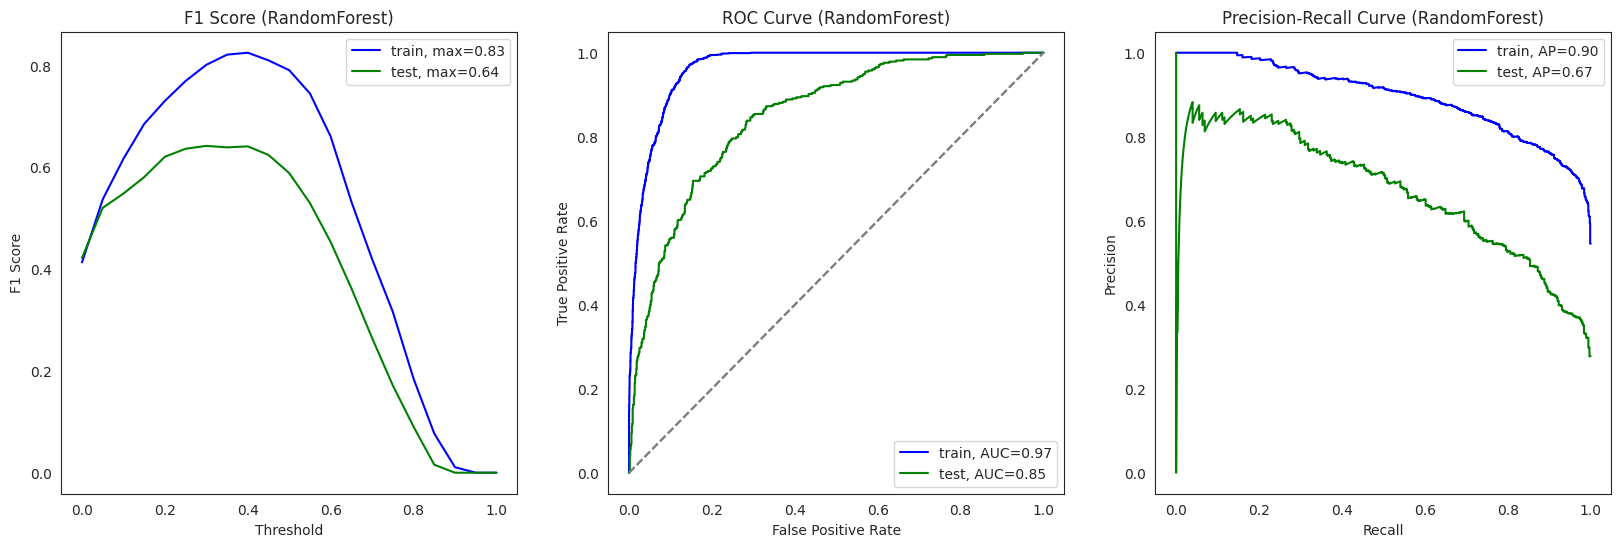


Evaluating DecisionTree...
          train  test
Accuracy   0.80  0.80
F1         0.59  0.58
APS        0.63  0.62
ROC AUC    0.85  0.84


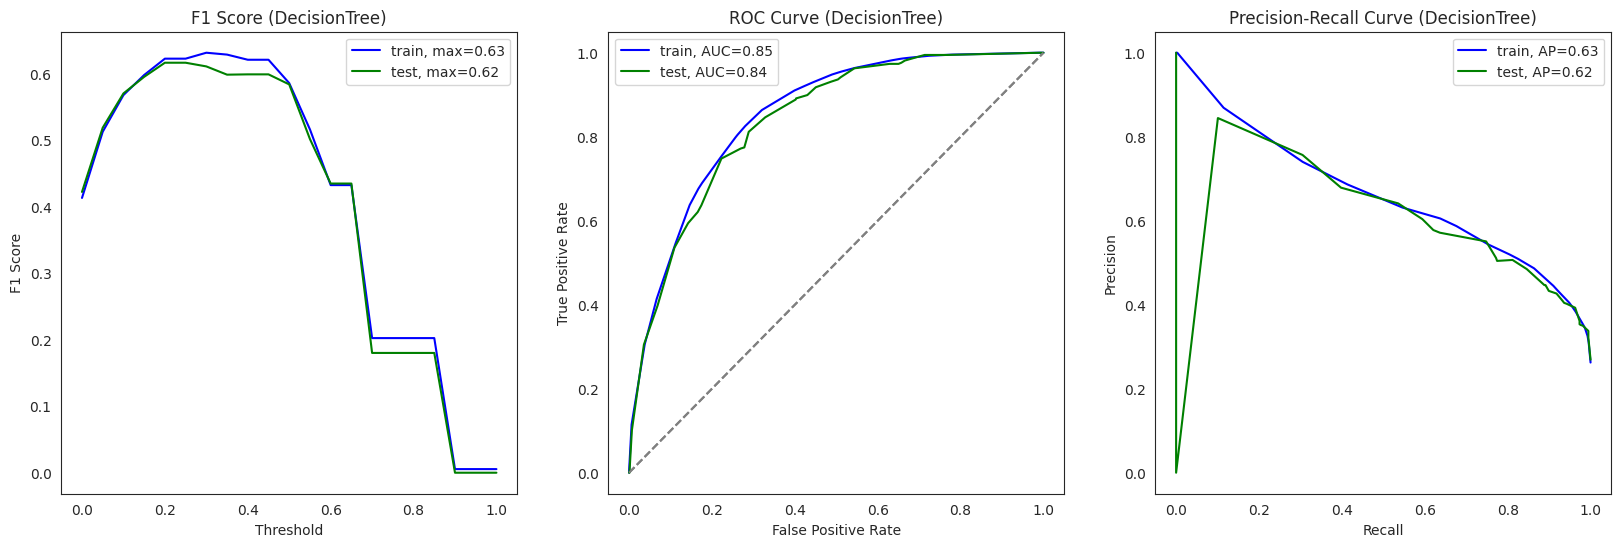


Evaluating GradientBoosting...
          train  test
Accuracy   0.89  0.82
F1         0.76  0.62
APS        0.87  0.68
ROC AUC    0.95  0.85


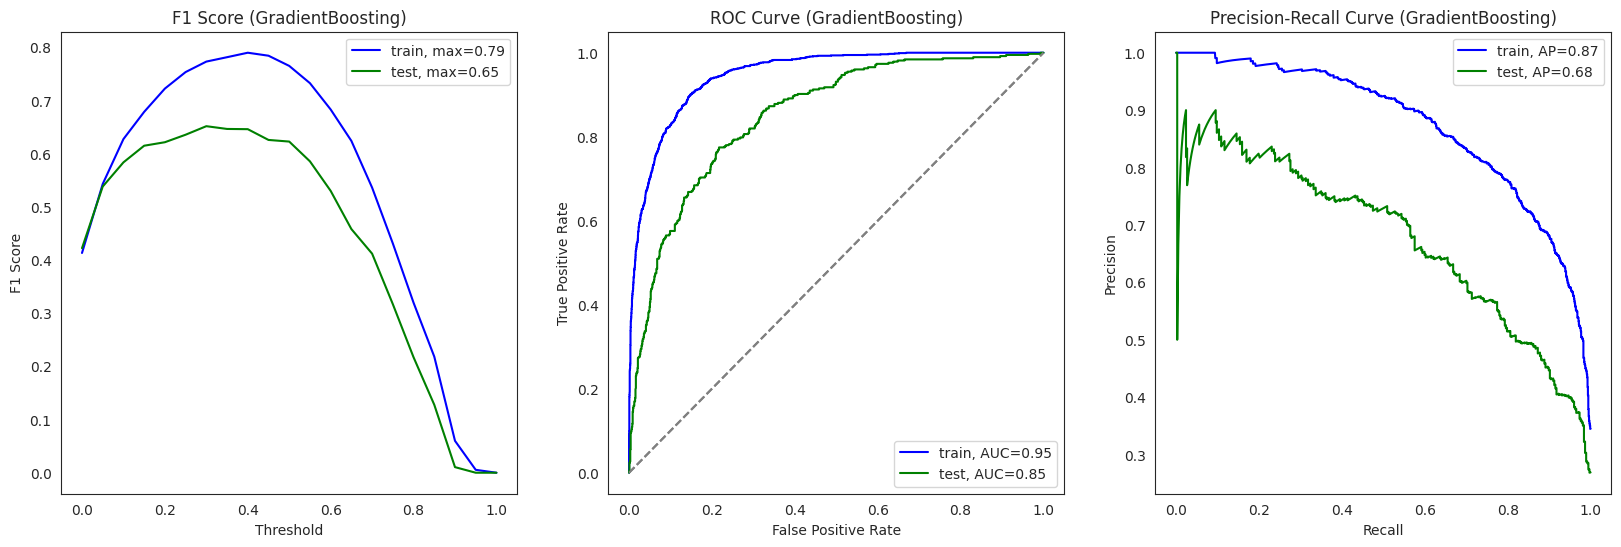


Evaluating LogisticRegression...
          train  test
Accuracy   0.80  0.80
F1         0.56  0.57
APS        0.63  0.66
ROC AUC    0.83  0.83


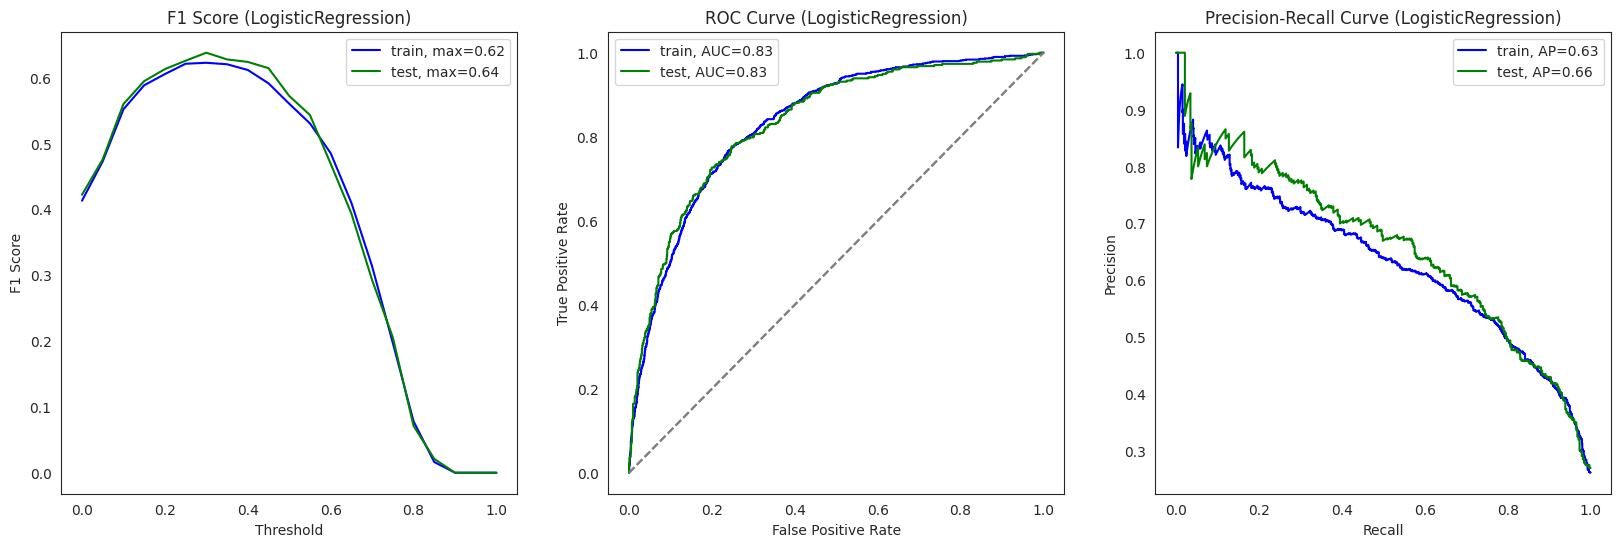


Evaluating XGBClassifier...
          train  test
Accuracy   0.95  0.79
F1         0.91  0.58
APS        0.97  0.65
ROC AUC    0.99  0.83


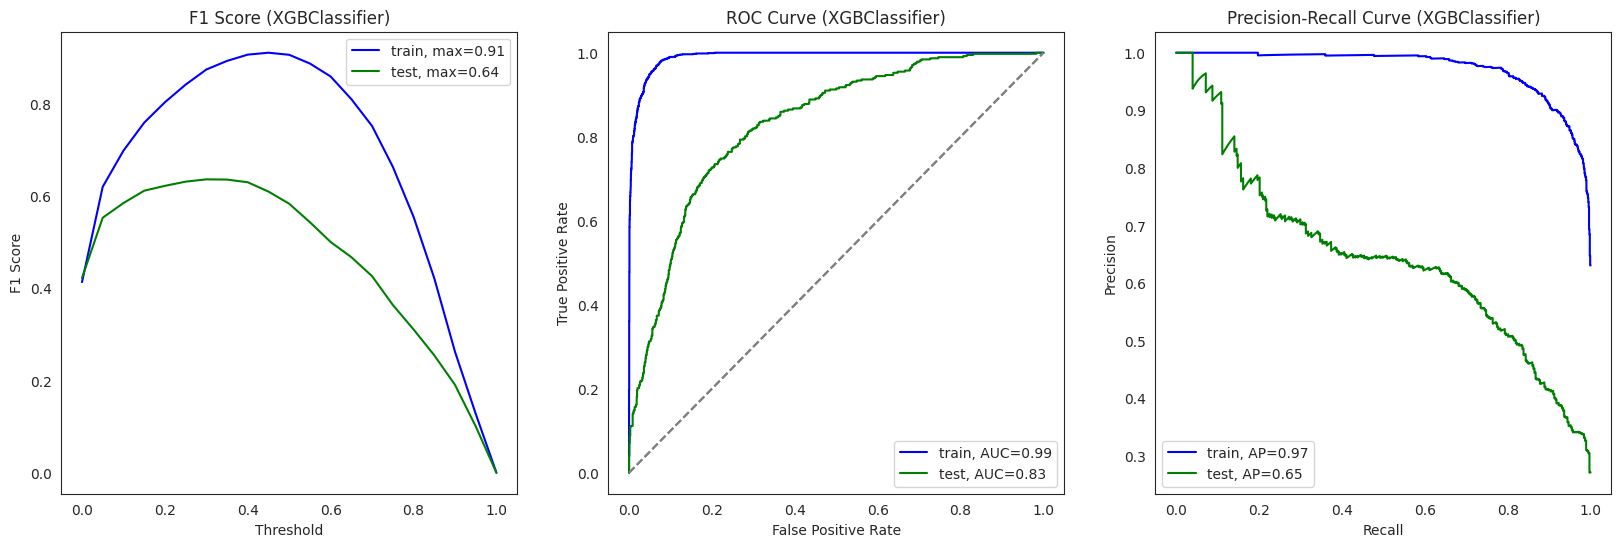


Evaluating LGBMClassifier...
          train  test
Accuracy   0.90  0.80
F1         0.79  0.60
APS        0.89  0.66
ROC AUC    0.96  0.84


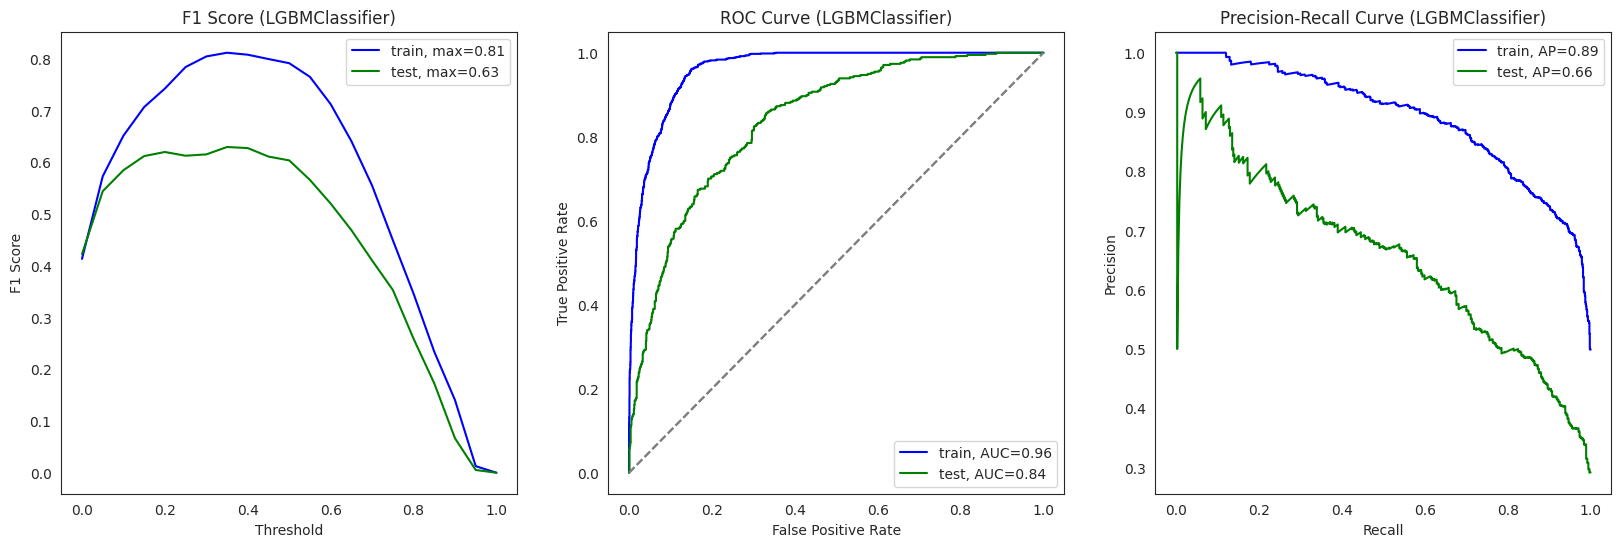


Evaluating CatBoost...
          train  test
Accuracy   0.87  0.81
F1         0.73  0.60
APS        0.85  0.69
ROC AUC    0.94  0.85


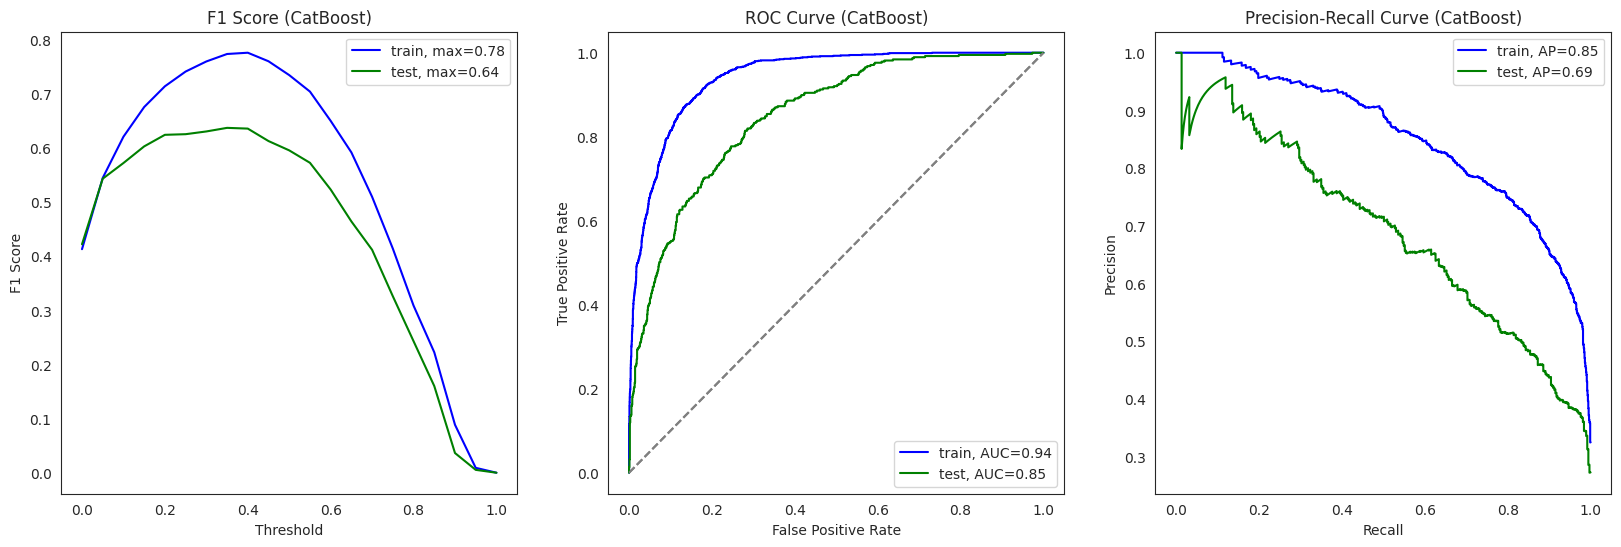

In [64]:
# Define models and their respective parameter grids
models_and_params = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'random_state': [42]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'max_depth': [3, 5, 10],
            'random_state': [42]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 10],
            'random_state': [42]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'param_grid': {}
    },
    'XGBClassifier': {
        'model': xgb.XGBClassifier(),
        'param_grid': {} 
    },
    'LGBMClassifier': {
        'model': lgb.LGBMClassifier(),
        'param_grid': {}
    },
    'CatBoost': {
        'model': CatBoostClassifier(),
        'param_grid': {}
    },
}

def train_models(models_and_params, features_train, target_train):
    trained_models = {}

    for model_name, config in models_and_params.items():
        print(f"\nRunning GridSearchCV for {model_name}...")

        # Hyperparameter tuning
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['param_grid'],
            cv=5,
            scoring='f1',
            n_jobs=-1
        )
        grid_search.fit(features_train, target_train)

        # Store the best model
        best_model = grid_search.best_estimator_
        trained_models[model_name] = best_model
        print(f"Best {model_name} Parameters: {grid_search.best_params_}")

    return trained_models

def evaluate_models(trained_models, features_train, target_train, features_test, target_test):
    for model_name, model in trained_models.items():
        print(f"\nEvaluating {model_name}...")
        evaluate_classification_model(model_name, model, features_train, target_train, features_test, target_test)

def evaluate_classification_model(model_name, model, features_train, target_train, features_test, target_test):
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for dataset_type, features, target in [('train', features_train, target_train), ('test', features_test, target_test)]:
        eval_stats[dataset_type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]  # Use the correct dataset

        # Compute metrics
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]
        fpr, tpr, _ = roc_curve(target, pred_proba)
        precision, recall, _ = precision_recall_curve(target, pred_proba)

        # Aggregate results
        eval_stats[dataset_type]['Accuracy'] = accuracy_score(target, pred_target)
        eval_stats[dataset_type]['F1'] = f1_score(target, pred_target)
        eval_stats[dataset_type]['ROC AUC'] = roc_auc_score(target, pred_proba)
        eval_stats[dataset_type]['APS'] = average_precision_score(target, pred_proba)

        color = 'blue' if dataset_type == 'train' else 'green'

        # F1 Score Plot
        ax = axs[0]
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{dataset_type}, max={max(f1_scores):.2f}')
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1 Score')
        ax.legend()
        ax.set_title(f'F1 Score ({model_name})')

        # ROC Curve
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{dataset_type}, AUC={roc_auc_score(target, pred_proba):.2f}')
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend()
        ax.set_title(f'ROC Curve ({model_name})')

        # Precision-Recall Curve
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{dataset_type}, AP={average_precision_score(target, pred_proba):.2f}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()
        ax.set_title(f'Precision-Recall Curve ({model_name})')

    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=['Accuracy', 'F1', 'APS', 'ROC AUC'])

    print(df_eval_stats)
    plt.show()

# Run training and evaluation separately
trained_models = train_models(models_and_params, features_train, target_train)
evaluate_models(trained_models, features_train, target_train, features_test, target_test)


In [65]:
def find_best_model_by_auc(trained_models, features_test, target_test):
    """Find the model with the highest ROC-AUC score on the test set."""
    best_model = None
    best_model_name = None
    best_auc = 0

    for model_name, model in trained_models.items():
        pred_proba = model.predict_proba(features_test)[:, 1]
        auc = roc_auc_score(target_test, pred_proba)

        print(f"{model_name} Test ROC-AUC: {auc:.4f}")

        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_model_name = model_name

    print(f"\nBest Model: {best_model_name} with ROC-AUC: {best_auc:.4f}")
    return best_model, best_model_name

# Find the best model based on ROC-AUC
best_model, best_model_name = find_best_model_by_auc(trained_models, features_test, target_test)

# Compute ROC-AUC on the validation set using the best model
best_val_pred_proba = best_model.predict_proba(features_valid)[:, 1]
auc_roc_val = roc_auc_score(target_valid, best_val_pred_proba)

print(f"AUC-ROC Score for Best Model ({best_model_name}) on Validation Set: {auc_roc_val:.4f}")


RandomForest Test ROC-AUC: 0.8504
DecisionTree Test ROC-AUC: 0.8380
GradientBoosting Test ROC-AUC: 0.8514
LogisticRegression Test ROC-AUC: 0.8331
XGBClassifier Test ROC-AUC: 0.8310
LGBMClassifier Test ROC-AUC: 0.8394
CatBoost Test ROC-AUC: 0.8496

Best Model: GradientBoosting with ROC-AUC: 0.8514
AUC-ROC Score for Best Model (GradientBoosting) on Validation Set: 0.3030


# Conclusion: 
Interconnect now has a successful model to discover the users at risk of leaving.  

Analyzing the data provided some interesting insights. Data provided was from earliest customer on 2013-10-01 to 202-02-01. Average time of a customer was 32.42 months. Average user spent $2,036 in total charges.  However, the longer a user was a customer the more they paid in total charges.User data provided was equally split between male and female.  In given informatio majority of users (around 5k) do not have dependents.  Yet nearly half of users have multiple lines on their accounts.  Perhaps an indication that majority of users have business lines.  Overall most users (around 8k) did not elect for any type of tech support (security or backup).  Streaming customrs are more likely to invest in tech support over online customers.  

Following models were evaluated: Random Forest, Decision Tree, Gradient Boosting, Logistic Regression,XGB, LGBM, and CatBoost. Results listed below are arranged per model listed above on the test model.  AUC-ROC was .84,.84,.85,.83,.83,.84,.85.  Precision was .62,.62,.68,.66,.65,.66,.69.  Accuracy was .80,.80,.82,.80,.79,.80,.81.  F1 score was .58,.58,.62,.57,.58,.60,.60.  Overall ranking of models to predict based on ROC would be GradientBoosting and CatBoost tied as the best.  Second place is a three way tie with Random Forest, LGBM, and Decision Treel.  Tied for third most effective is XGB and Logisitc Regression.  

Chose to evaluate with AUC-ROC, F1, Accurary, and Precision-Recall to see which would be the best measurment. F1 Score balances precision and recall by penalizing extreme values.  F1 does not differentiate between false positives and false negatives at an alarmingly high rate.  So we would not want to use. In our data we balanced between customers who had churned and customers who had remained. Precision-Recall Curve measures the trade-off between Precision and Recall at various thresholds. Works best on highly imbalanced datasets so it is not good for our data. Accuracy measures the percentage of correctly classified instances. Best for a balanced dataset (such as ours). ROC Curve measures the trade-off between True Positive Rate (TPR, Sensitivity/Recall) and False Positive Rate (FPR) at various classification thresholds.  The closer to 1 indicates a perfect model (highest achieved by Gradient Boosting at .85).  Either accuracy or AUC-ROC could be used to measure the success of the model.  Ranking of models is mostly same between accuracy or AUC-ROC.  Only note is that in using accuracy XBG joins second place to make a four way tie. 


Final Report

All steps described in the plan were performed.  All four source files were uploaded. A function was crafted to check each file for duplicates, zero values, empty cells, and print a sample.  Some exploratory research was done to learn more regarding each data frame.  Finding the earliest date of customer aquisition and most recent date.  Confirming the number and types of genders being listed.  Determie the spending of average user.  Search for nonnumric results in the priority column of 'totalcharge.  Once it was discovered there was only .0002% of nonumeric data a decision was made to delete those.  There were many rows with NA listed for 'enddate' but decided to replace with the max value of enddate.  Preparation for machine learning began.  Many columns contained information with datatypes of object or boolean values. These were replaced with numerics so the datatypes could be acceptable for machine learning (int64 or float). 

All cleaned EDA files were combined into one dataframe on common column of 'customerid'.  Performing this step created lots of zero and Nan values to be adressed.  Choose to replace all Nan values with zereos.  Performed some feature engineering. A column was added of boolean values to represent whether or not a customr had churned.  Anothr column was created to show the determinant of each user as a high/low spender compared to the average.  Data was checked for seasonal trends but none were discovered.  

Machine Learning began.  The entire dataframe was split into training, test, and validation dataframes.  The features and target were identified for each of the seperated dataframes.  This step showed that there was a large class imbalance between churned customers and present customers. The next step was to upample rows in features_train for users who had churned to create class balance.  The train and test data were scaled. To prdict whether or not users would churn was identified as a classifiction problem.  The models were chosen with parameters to evaluate (Random Forest, Decision Tree, Gradient Boosting, Logistic Regression,XGB, LGBM, and CatBoost).  A loop was created to use GridSearch to find best hyperparameters (for applicable models).  The defined loop fit the training and test data to each of the models.  Each model was evaluated for precision, f1 score, accuracy, and auc-roc.  

Difficulties were encountred preforming the project. Some I encountered are listed below:
Initially I incorrectly identified the issue as a regression problem.  This generated poor results when testing on regression models. 

I chose to fill in NAN of 'enddate'originally with a timestamp for the current data.  My idea was that then I could sort to say that all the rows with todays date were still customers.  However that overly complicated the task since the date wouold change everytime the project was run and need to have code changed in the later part of the project.  This also caused data leakage so original models were overfit. Eventually chose to fill them with the maximum value of the 'begindate'.  

Mistakenly scaled and upsampled entire dataframe of combined files rather than only the training dataframe.This was corrected to only be the features_train df after train_test_split had been performed.  

Initially took that the 5,000 rows present in one of the files was the limiting factor of data to include.  Adjusted so that all data was used and addressed zeros and NANs created by utilizing all of the data provided. 

It was difficult to create a loop to evauate model parameters and perform classification taks with graphs that did not take hours.  Eventually accomplished by splitting into multiple functions.   

I thought a trend would be obviously by seasonality.  At first the graphs looked indecipherable once evaluated with seasonal_decompose.  This was because the churn date had been bouncing back and forth between actual churn dates and when I had imposed 2025 as being a churn date for users who were still customers.  As described above that was replaced with the 'begindate'.  Then I chose to sort the combined dataframe in acending values by 'enddate' and then by 'monthly charges'.  This made the graph not have static of values bouncing back and forth.  The graphs continue to look odd though.  Unsure how to correct or any insights which could be gained from them.  

Once models were run some of my results were .95 or 1.0 ROC-AUC.  This was rare and not to be expected.  It took the help of a tutor in review to realize the issue.  I performed train_test_split. However when I defined features/targt for train/test/validation I was assigning it from the dataframe 'entire' rather than from 'enitre_test/train/valid'.  So every model was running the exact same data for train and test.  Error was corrected before submission of task for review.  

Final model used was GradientBoosting.  This consistnelty had th highest ROC-AUC of 0.8514. Project contained some surprising insights.  It was concerning to me tha the longer a user was a customer the more they ended up paying. That is poor customer servie and understandable why customers would churn.  It was strange to see that most users did not claim dependents but that they had multiple lines.  Is the company mainly providing business lines? Seems unlikely since most business phones in practice are paid directly by employer.  Why would people need multiple lines if not business? Is there another negative tax consequence that users wouold not want to report having dependents? This is a contiued unknown from given data.  Overall I am appreciative that this project gave ample opportuity to demonstrate knowledge and learn from my mistakes.  I feel very joyful to have been able to create high scoring results.  